In [1]:
# Common initialisation, constants, etc.

import os.path
import numpy as np
import pandas
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=8)
plt.rc('figure', dpi=200)
plt.rc('axes', axisbelow=True, titlesize=5)
plt.rc('lines', linewidth=1)
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.animation import FuncAnimation

rcparams = {
    'axes.labelsize':6,
    'axes.titlesize':7,
    'font.size':6,
    'legend.fontsize':6,
    'xtick.labelsize':6,
    'ytick.labelsize':6,
    'text.usetex': False,
    'figure.figsize': [3.5, 3.5]    
}

plt.rcParams.update(rcparams)

# font = {'family':'serif', 'color':'black', 'weight':'normal', 'size':10}

# Define some useful array accessor constants
POS_X  = 0    # x-coordinates of agents position
POS_Y  = 1    # y-coordinates of agents position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
DIR_X  = 6    # x-coordinates of direction vectors
DIR_Y  = 7    # y-coordinates of direction vectors
RES_X  = 8    # x-coordinates of resultant vectors
RES_Y  = 9    # y-coordinates of resultant vectors
GOAL_X = 10   # x-coordinates of goals
GOAL_Y = 11   # y-coordinates of goals
PRM    = 12   # if True agent known to be on perimeter of swarm
GAP_X  = 13   # x-coordinates of vector for gap reduction
GAP_Y  = 14   # y-ccordinates of vector for gap reduction
COH_N  = 15   # number of cohesion neighbours
REP_N  = 16   # number of repulsion neighbours

N_ROWS = 17   # number of rows in array that models swarm state
eps    = np.finfo('float64').eps # smallest positive 64 bit float value

default_swarm_params = {
    'cb' : 3.0,
    'rb' : [[2.0,2.0],[2.0,2.0]],
    'kc' : [[0.15,0.15],[0.15,0.15]],
    'kr' : [[50.0,50.0],[50.0,50.0]],
    'kd' : 0.0,
    'kg' : 0.0,
    'scaling' : 'linear',
    'exp_rate' : 0.2,
    'speed' : 0.05,
    'stability_factor' : 0.0,
    'perim_coord' : 'false',
    'rgf' : False
}

def mk_rand_swarm(n, *, goal=[[0.0], [0.0]], loc=0.0, grid=10, seed=None):
    '''
    create a 2-D array of N_ROWS attributes for n agents.

    :param n:      number of agents
    :param goal:   location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    :param loc:    location of agent b_0 -- the focus of the swarm
    :param grid:   size of grid around b_0 in which all other agents will be placed initially at random
    :param seed:   initial seed for random number generation
    '''
    b = np.empty((N_ROWS, n))                       #create a 2-D array, big enough for n agents
    prng = np.random.default_rng(seed)
    np.copyto(b[POS_X:POS_Y + 1,:], (prng.random(size=2 * n) * 2 * grid - grid + loc).reshape(2, n)) # place agents randomly
    b[POS_X:POS_Y + 1,0] = loc                      # b_0 placed at [loc, loc]
    b[COH_X:COH_Y+1,:] = 0.                         # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = 0.                         # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = 0.                         # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = 0.                       # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = goal                   # goal is at [goal[0], goal[1]], default [0.0, 0.0]
    b[PRM,:] = False                                # initially no agents known to be on perimeter
    b[GAP_X:GAP_Y+1,:] = 0.                         # gap vectors initially [0.0, 0.0]
    b[COH_N,:] = 0.                                 # initially no cohesion neighbours
    b[REP_N,:] = 0.                                 # initially no repulsion neighbours
    return b

def mk_swarm(xs, ys, *, goal=[[0.0], [0.0]]):
    '''
    create a 2-D array of N_ROWS attributes for len(xs) agents.

    :param xs:      x-values of position of agents
    :param ys:      y-values of position of agents
    :param goal:    location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    '''
    n = len(xs)
    assert len(ys) == n
    b = np.empty((N_ROWS, n))                       # create a 2-D array, big enough for n agents
    np.copyto(b[POS_X], xs)                         # place agents as specified
    np.copyto(b[POS_Y], ys)                         # place agents as specified
    b[COH_X:COH_Y+1,:] = 0.                         # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = 0.                         # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = 0.                         # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = 0.                       # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = goal                   # goal is at [goal, goal], default [0.0, 0.0]
    b[PRM,:] = False                                # initially no agents known to be on perimeter
    b[GAP_X:GAP_Y+1,:] = 0.                         # gap vectors initially [0.0, 0.0]
    b[COH_N,:] = 0.                                 # initially no cohesion neighbours
    b[REP_N,:] = 0.                                 # initially no repulsion neighbours
    return b

In [2]:
# Numba-accelerated simulator

from numba import jit, prange

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def all_pairs_mag(b, xv, yv, mag, cb):
    n_agents = b.shape[1]
    b[COH_N].fill(0.)
    for i in range(n_agents):
        for j in range(i):
            xv[i,j] = b[POS_X][i] - b[POS_X][j]
            xv[j,i] = -xv[i,j]
            yv[i,j] = b[POS_Y][i] - b[POS_Y][j]
            yv[j,i] = -yv[i,j]
            mag[i,j] = np.sqrt(xv[i,j] ** 2 + yv[i,j] ** 2)
            mag[j,i] = mag[i,j]
            if mag[j,i] <= cb:
                b[COH_N][i] = b[COH_N][i] + 1
                b[COH_N][j] = b[COH_N][j] + 1
        xv[i,i] = 0.0
        yv[i,i] = 0.0
        mag[i,i] = 0.0

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_coh(b, xv, yv, mag, cb, kc, p):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[COH_X][i] = 0.0
        b[COH_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= cb:
                b[COH_X][i] = b[COH_X][i] + (xv[j,i] * kc[p[i],p[j]])
                b[COH_Y][i] = b[COH_Y][i] + (yv[j,i] * kc[p[i],p[j]])

@jit(nopython=True, fastmath=True, cache=True)
def nbr_sort(a, ang, i):
    n = a.shape[0]
    for j in range(n):
        jmin = j
        for k in range(j, n):
            if (ang[:,i][a[k]] < ang[:,i][a[jmin]]):
                jmin = k
        if jmin != j:
            a[jmin], a[j] = a[j], a[jmin]


@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def onPerim(b, xv, yv, mag, cb, kg, rgf):
    n_agents = b.shape[1]
    result = np.full(n_agents, False)
    ang = np.arctan2(yv, xv)                    # all pairs polar angles
    for i in prange(n_agents):
        b[GAP_X][i] = 0.
        b[GAP_Y][i] = 0.
        if b[COH_N][i] < 3:
            result[i] = True
            continue
        nbrs = np.full(int(b[COH_N][i]), 0)
        k = 0
        for j in range(n_agents):
            if j != i and mag[j, i] <= cb:
                nbrs[k] = j
                k += 1
        nbr_sort(nbrs, ang, i)
        for j in range(int(b[COH_N][i])):
            k = (j + 1) % int(b[COH_N][i])
            if mag[nbrs[k],nbrs[j]] > cb:    # nbrs[j] and nbrs[k] are not cohesion neighbours
                result[i] = True
                # compute the gap vector in case of gap reduction - out of cohesion range
                b[GAP_X][i] += kg * ((0.5 * (b[POS_X][nbrs[k]] + b[POS_X][nbrs[j]])) - b[POS_X][i])
                b[GAP_Y][i] += kg * ((0.5 * (b[POS_Y][nbrs[k]] + b[POS_Y][nbrs[j]])) - b[POS_Y][i])
                break
            else:
                delta = ang[:,i][nbrs[k]] - ang[:,i][nbrs[j]]
                if (delta < 0):
                    delta += np.pi * 2.0;
                if (delta > np.pi):
                    result[i] = True;
                    # compute the gap vector in case of gap reduction - reflex angle
                    if rgf:
                        b[GAP_X][i] += kg * ((0.5 * (b[POS_X][nbrs[k]] + b[POS_X][nbrs[j]])) - b[POS_X][i])
                        b[GAP_Y][i] += kg * ((0.5 * (b[POS_Y][nbrs[k]] + b[POS_Y][nbrs[j]])) - b[POS_Y][i])
                    break
    return result.astype(np.int64), ang

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_rep_linear(b, xv, yv, mag, rb, kr, p):
    '''
    :param b: the state of the swarm
    :param xv: x component of all pairwise vectors
    :param yv: y component of all pairwise vectors
    :param mag: magnitude of all pairwise vectors
    :param rb: repulsion field radius
    :param kr: weighting of repulsion vector
    :param p: perimeter status of all agents
    '''
    n_agents = b.shape[1]
    p = b[PRM].astype(np.int64)
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= rb[p[i],p[j]]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + (1. - (rb[p[i],p[j]] / mag[j,i])) * xv[j,i] * kr[p[i],p[j]]
                b[REP_Y][i] = b[REP_Y][i] + (1. - (rb[p[i],p[j]] / mag[j,i])) * yv[j,i] * kr[p[i],p[j]]

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_rep_quadratic(b, xv, yv, mag, rb, kr, p):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= rb[p[i],p[j]]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + (-rb[p[i],p[j]] * (mag[j,i] ** -2) * (xv[j,i] / mag[j,i]) * kr[p[i],p[j]])
                b[REP_Y][i] = b[REP_Y][i] + (-rb[p[i],p[j]] * (mag[j,i] ** -2) * (yv[j,i] / mag[j,i]) * kr[p[i],p[j]])

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_rep_exponential(b, xv, yv, mag, rb, kr, p, exp_rate):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= rb[p[i],p[j]]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + (-rb[p[i],p[j]] * (np.e ** (-mag[j,i] * exp_rate)) * (xv[j,i] / mag[j,i]) * kr[p[i],p[j]])
                b[REP_Y][i] = b[REP_Y][i] + (-rb[p[i],p[j]] * (np.e ** (-mag[j,i] * exp_rate)) * (yv[j,i] / mag[j,i]) * kr[p[i],p[j]])

@jit(nopython=True, fastmath=True, cache=True)
def update_resultant(b, stability_factor, speed):
    n_agents = b.shape[1]
    for i in range(n_agents):
        mag_res = np.sqrt(b[RES_X][i] ** 2 + b[RES_Y][i] ** 2)
        if mag_res > stability_factor * speed:
            b[RES_X][i] = b[RES_X][i] / mag_res * speed
            b[RES_Y][i] = b[RES_Y][i] / mag_res * speed
        else:
            b[RES_X][i] = 0.0
            b[RES_Y][i] = 0.0

def compute_step(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perim_coord=False, stability_factor=0.0, cb=4.0, rb=np.array([[3.0,3.0],[3.0,3.0]]), kc=np.array([[1.0,1.0],[1.0,1.0]]), kr=np.array([[1.0,1.0],[1.0,1.0]]), kd=0.0, kg=0.0, rgf=False):
    """
    Compute one step in the evolution of swarm `b`, update the COH, REP, DIR and RES fields
    
    :param b: the array modelling the state of the swarm
    :param scaling: choose 'linear', 'quadratic', or 'exponential' scaling of repulsion vectors
    :param exp_rate: rate of scaling in 'exponential' case
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step)
    :param perim_coord: if True then use only the perimeter agents in computing the direction vector
    :param stability_factor: if the magnitude of an agent's resultant vector is less than speed * stability_factor then agent does not move
    :param cb: the radius of the cohesion field
    :param rb: a 2x2 array defining the radius of the repulsion field based on perimeter relationships
    :param kc: a 2x2 array defining the weighting of the cohesion vector based on perimeter relationships
    :param kr: a 2x2 array defining the weighting of the repulsion vector based on perimeter relationships
    :param kd: a scalar defining the weighting of the direction vector 
    :param kg: a scalar defining the weighting of the gap vector
    :param rgf: a boolean which if True cause gap-filling on reflex angles
    """
    # print(scaling, exp_rate, speed, perim_coord, stability_factor, pr)
    n_agents = b.shape[1]
    xv = np.empty((n_agents, n_agents))
    yv = np.empty((n_agents, n_agents))
    mag = np.empty((n_agents, n_agents))
    all_pairs_mag(b, xv, yv, mag, cb)

    # compute the perimeter, including gap vectors for gap reduction
    p, ang = onPerim(b, xv, yv, mag, cb, kg, rgf)
    b[PRM] = p

    # compute the cohesion vectors
    compute_coh(b, xv, yv, mag, cb, kc, p)
    b[COH_X:COH_Y+1] /= np.maximum(b[COH_N], 1)         # divide by the number of cohesion neighbours

     # compute the repulsion vectors
    if scaling == 'linear':
        compute_rep_linear(b, xv, yv, mag, rb, kr, p)
    elif scaling == 'quadratic':
        compute_rep_quadratic(b, xv, yv, mag, rb, kr, p)
    elif scaling == 'exponential':
        compute_rep_exponential(b, xv, yv, mag, rb, kr, p, exp_rate)
    else:
        assert(False)                                   # something's gone wrong here
    b[REP_X:REP_Y+1] /= np.maximum(b[REP_N], 1)         # divide by the number of repulsion neighbours

    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = kd * (b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1])

    # compute the resultant of the cohesion, repulsion and direction vectors
    if perim_coord:
        b[DIR_X:DIR_Y+1] *= b[PRM]
    b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[GAP_X:GAP_Y+1] + b[REP_X:REP_Y+1] + b[DIR_X:DIR_Y+1]

    # normalise the resultant and update for speed, adjusted for stability
    update_resultant(b, stability_factor, speed)

    return xv, yv, mag, ang, cb                 # helpful in calculation of metrics, instrumentation, debugging

def apply_step(b):
    """
    Assuming the step has been computed so that RES fields are up to date, update positions
    """
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]
    np.around(b[POS_X:POS_Y+1], 9, out=b[POS_X:POS_Y+1])

def d_step(b, *, scaling='linear', exp_rate=1.2, speed=0.05, perim_coord=False, stability_factor=0.0, cb=4.0, rb=np.array([[3.0,3.0],[3.0,3.0]]), kc=np.array([[1.0,1.0],[1.0,1.0]]), kr=np.array([[1.0,1.0],[1.0,1.0]]), kd=0.0, kg=0.0, rgf=False):
    xv,yv,mag,ang,cb = compute_step(b, scaling=scaling, exp_rate=exp_rate, speed=speed, perim_coord=perim_coord, stability_factor=stability_factor, cb=cb, rb=rb, kc=kc, kr=kr, kd=kd, kg=kg, rgf=rgf)
    apply_step(b)
    return xv,yv,mag,ang,cb

In [3]:
# Latest pure numpy model (for comparison)

def all_pairs_mag2(b):
    xv = np.subtract.outer(b[POS_X], b[POS_X])  # all pairs x-differences
    yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # all pairs y-differences
    # compute all pairwise vector magnitudes
    mag = np.hypot(xv, yv)              # all pairs magnitudes
    return xv, yv, mag

def compute_coh2(b, xv, yv, coh_n, ekc):
    # compute the x-differences and y-differences for cohesion vectors
    xv_coh = np.where(coh_n, xv * ekc, 0.0)
    yv_coh = np.where(coh_n, yv * ekc, 0.0)

    # compute the cohesion vectors 
    b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
    b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
    return coh_n, xv_coh, yv_coh

def onPerim2(b, xv, yv, mag, coh_n, kg, rgf):
    """
    Determines the perimeter status of all agents in swarm b. Can make use of previous computations,
    if available, to improve overall efficiency.
    
    :param b: a data structure representing the swarm
    :param xv: all pairs differences in x-values
    :param yv: all pairs differences in y-values
    :param mag: all pairs distances between agents
    :param coh_n: all pairs cohesion neighbour status
    :returns: a numpy array of bools, one element per agent set to True if agent is on perimeter and False otherwise
    """
    ang = np.arctan2(yv, xv)                    # all pairs polar angles
    ang_coh = np.where(coh_n, ang, 10.0)        # polar angle for pairs of agents within coh range; otherwise dummy value of 10
    b[GAP_X:GAP_Y+1,:] = 0
    i = 0
    gap_found = False
    
    def isAgentOnPerimeter(nba):
        """
        Determines the perimeter status of a single agent
        
        :param nba: array of neighbour angles for all cohesion neighbours of one agent
        :returns: True if perimeter condition is satisfied, otherwise False
        """
        nonlocal i, gap_found
        nr = np.count_nonzero(nba<10)   # angles of coh neighbours are nba[i] for 0 <= i < nr
        if nr < 3:                     # agent has no nbrs ... 
            is_on_perimeter = True      # ... so perimeter condition satisfied immediately
        else:
            nbi = np.argsort(nba, axis=0).astype(int)[0:nr] # nbi indexes nba in ascending order of angle, losing dummy values
            adj = np.row_stack((nbi, np.roll(nbi,-1)))      # 2 x nr array of adjacent neighbours in which for 0 <= i < nr, adj[0, i] == nbi[i] and adj[1, i] == nbi[i + 1 % nr]

            def perimeterTest(p):           # the helper's helper
                """
                Tests if a pair of an agent's adjacent neighbours give the agent the 'perimeter-iness' property
                
                :param p: p is an array of shape (2,1) in which p[0] and p[1] are a pair of adjacent neighbours in polar angle order
                """
                nonlocal gap_found
                result = False
                if not coh_n[p[1],p[0]]:    # the adjacent pair are not cohesion neighbours of each other ...
                    result = True           # ... so the agent under consideration is on the perimeter
                    if not gap_found:
                        b[GAP_X][i] = kg * ((0.5 * (b[POS_X][p[1]] + b[POS_X][p[0]]) - b[POS_X][i]))
                        b[GAP_Y][i] = kg * ((0.5 * (b[POS_Y][p[1]] + b[POS_Y][p[0]]) - b[POS_Y][i]))
                        gap_found = True
                else:
                    delta = nba[p[1]] - nba[p[0]]   # compute the angle between the adjacent neighbour pair
                    if (delta < 0):
                        delta += np.pi * 2.0;
                    if (delta > np.pi):
                        result = True;
                        # compute the gap vector in case of gap reduction - reflex angle
                        if rgf and not gap_found:
                            b[GAP_X][i] = kg * ((0.5 * (b[POS_X][p[1]] + b[POS_X][p[0]]) - b[POS_X][i]))
                            b[GAP_Y][i] = kg * ((0.5 * (b[POS_Y][p[1]] + b[POS_Y][p[0]]) - b[POS_Y][i]))
                            gap_found = True
                return result
            
            is_on_perimeter = np.any(np.apply_along_axis(perimeterTest, 0, adj))    # agent is on perimeter if any pair of its adjacent cohesion neighbours satisfies the perimeter test
            i += 1
            gap_found = False
        return is_on_perimeter

    return np.apply_along_axis(isAgentOnPerimeter, 0, ang_coh), ang

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_parameters2(n, rb, kc, kr, p):
    erb = np.empty((n,n))   
    ekc = np.empty((n,n))   
    ekr = np.empty((n,n)) 
    for j in prange(n):
        for i in range(n):
            erb[j, i] = rb[p[i], p[j]]
            ekc[j, i] = kc[p[i], p[j]]
            ekr[j, i] = kr[p[i], p[j]]
    return erb, ekc, ekr

def compute_rep_linear2(b, xv, yv, mag, erb, ekr):
    # compute the repulsion neighbours
    rep_n = mag <= erb
    np.fill_diagonal(rep_n, False)                     # no agent is a repulsion neighbour of itself
    b[REP_N,:] = np.sum(rep_n, axis = 0)               # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    rscalar = (1. - (erb[rep_n] / mag[rep_n]))
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] * rscalar * ekr[rep_n]    # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] * rscalar * ekr[rep_n]    # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
    return rep_n, xv_rep, yv_rep

def compute_rep_quadratic2(b, xv, yv, mag, erb, ekr):
    rep_n = mag <= erb
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    b[REP_N,:] = np.sum(rep_n, axis = 0) # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    mag_nz = np.where(mag != 0, mag, eps)                                  
    rscalar = (rep_n * -erb)[rep_n] * (mag_nz[rep_n] ** (-2))
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
    return rep_n, xv_rep, yv_rep

def compute_rep_exponential2(b, xv, yv, mag, erb, ekr, exp_rate):
    rep_n = mag <= erb
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    b[REP_N,:] = np.sum(rep_n, axis = 0) # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    mag_nz = np.where(mag != 0, mag, eps)                                  
    rscalar = (rep_n * -erb)[rep_n] * (np.e ** (-mag[rep_n] * exp_rate))
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
    return rep_n, xv_rep, yv_rep

def update_resultant2(b, stability_factor, speed):
    mag_res = np.broadcast_to(np.hypot(b[RES_X], b[RES_Y]), b[RES_X:RES_Y+1].shape)
    enz = mag_res > stability_factor * speed                                           # mag effectively non-zero
    b[RES_X:RES_Y+1][enz] = b[RES_X:RES_Y+1][enz] / mag_res[enz] * speed
    b[RES_X:RES_Y+1][np.logical_not(enz)] = 0.0

def compute_step2(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perim_coord=False, stability_factor=0.0, cb=4.0, rb=np.array([[3.0,3.0],[3.0,3.0]]), kc=np.array([[1.0,1.0],[1.0,1.0]]), kr=np.array([[1.0,1.0],[1.0,1.0]]), kd=0.0, kg=0.0, rgf=False, log=None):
    """
    Compute one step in the evolution of swarm `b`, update the COH, REP, DIR and RES fields
    
    :param b: the array modelling the state of the swarm
    :param scaling: choose 'linear', 'quadratic', or 'exponential' scaling of repulsion vectors
    :param exp_rate: rate of scaling in 'exponential' case
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step)
    :param perim_coord: if True then use only the perimeter agents in computing the direction vector
    :param stability_factor: if the magnitude of an agent's resultant vector is less than speed * stability_factor then agent does not move
    :param cb: the radius of the cohesion field
    :param rb: a 2x2 array defining the radius of the repulsion field based on perimeter relationships
    :param kc: a 2x2 array defining the weighting of the cohesion vector based on perimeter relationships
    :param kr: a 2x2 array defining the weighting of the repulsion vector based on perimeter relationships
    :param kd: a scalar defining the weighting of the direction vector 
    :param kg: a scalar defining the weighting of the gap vector
    :param rgf: a boolean which if True cause gap-filling on reflex angles
    """
    
    n_agents = b.shape[1]
    xv, yv, mag = all_pairs_mag2(b)
    
   # compute the cohesion neighbours
    coh_n = mag <= cb
    np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
    b[COH_N] = np.sum(coh_n, axis = 0) # number of cohesion neighbours

    # compute the perimeter
    b[PRM], ang = onPerim2(b, xv, yv, mag, coh_n, kg, rgf)
    p = b[PRM].astype(np.int64)

    # compute the effective parameters
    erb, ekc, ekr = compute_parameters2(n_agents, rb, kc, kr, p)
    
    # compute the cohesion vectors 
    coh_n, xv_coh, yv_coh = compute_coh2(b, xv, yv, coh_n, ekc)
    b[COH_X:COH_Y+1] /= np.maximum(b[COH_N], 1)         # divide by the number of cohesion neighbours

     # compute the repulsion vectors
    if scaling == 'linear':
        rep_n, xv_rep, yv_rep = compute_rep_linear2(b, xv, yv, mag, erb, ekr)
    elif scaling == 'quadratic':
        rep_n, xv_rep, yv_rep = compute_rep_quadratic2(b, xv, yv, mag, erb, ekr)
    elif scaling == 'exponential':
        rep_n, xv_rep, yv_rep = compute_rep_exponential2(b, xv, yv, mag, erb, ekr, exp_rate)
    else:
        assert(False)                                   # something's gone wrong here
    b[REP_X:REP_Y+1] /= np.maximum(b[REP_N], 1)         # divide by the number of repulsion neighbours
    
    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = kd * (b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1])

    # compute the resultant of the cohesion, repulsion and direction vectors
    if perim_coord:
        b[DIR_X:DIR_Y+1] *= b[PRM]
    b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[GAP_X:GAP_Y+1] + b[REP_X:REP_Y+1] + b[DIR_X:DIR_Y+1]
                  
    # normalise the resultant and update for speed, adjusted for stability    
    update_resultant2(b, stability_factor, speed)
    
    # log data if required
    if log is not None:
        for i in range(n_agents):
            for j in range(n_agents):
                if coh_n[i,j]:
                    log['c'].write(f"{log['step']},{i},{b[POS_X,i]},{b[POS_Y,i]},{b[PRM,i].astype(bool)},"
                                   f"{j},{b[POS_X,j]},{b[POS_Y,j]},{b[PRM,j].astype(bool)},"
                                   f"{xv_coh[j,i]},{yv_coh[j,i]},{np.hypot(xv_coh[j,i],yv_coh[j,i])},{mag[j,i]}\n")
                if rep_n[i,j]:
                    log['r'].write(f"{log['step']},{i},{b[POS_X,i]},{b[POS_Y,i]},{b[PRM,i].astype(bool)},"
                                   f"{j},{b[POS_X,j]},{b[POS_Y,j]},{b[PRM,j].astype(bool)},"
                                   f"{xv_rep[j,i]},{yv_rep[j,i]},{np.hypot(xv_rep[j,i],yv_rep[j,i])}\n")
        
    return xv, yv, mag, ang, cb, xv_coh, yv_coh, xv_rep, yv_rep    # helpful in the calculation of metrics and for debugging

def apply_step2(b):
    # update positions
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]
    np.around(b[POS_X:POS_Y+1], 9, out=b[POS_X:POS_Y+1])

def d_step2(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perim_coord=False, stability_factor=0.0, cb=4.0, rb=np.array([[3.0,3.0],[3.0,3.0]]), kc=np.array([[1.0,1.0],[1.0,1.0]]), kr=np.array([[1.0,1.0],[1.0,1.0]]), kd=0.0, kg=0.0, rgf=False, log=None):    
    xv,yv,mag,ang,cb,xv_coh,yv_coh,xv_rep,yv_rep = compute_step2(b, scaling=scaling, exp_rate=exp_rate, speed=speed, perim_coord=perim_coord, stability_factor=stability_factor, cb=cb, rb=rb, kc=kc, kr=kr, kd=kd, kg=kg, rgf=rgf, log=log)
    apply_step2(b)
    return xv,yv,mag,ang,cb,xv_coh,yv_coh,xv_rep,yv_rep

In [805]:
# Some utility functions

import json

'''
Data persistence methods
'''

def dump_state(b, step_args_ro, path='swarm.json'):
    b_list = b.tolist()
    step_args = step_args_ro.copy()
    step_args['rb'] = step_args['rb'].tolist()
    step_args['kc'] = step_args['kc'].tolist()
    step_args['kr'] = step_args['kr'].tolist()
    state = {
        'params': {**default_swarm_params, **step_args},
        'b_list': b_list,
    }
    with open(path, 'w') as f:
        json.dump(state, f, indent=4)
        f.close()
        
def load_state(path='swarm.json'):
    with open(path, 'r') as f:
        state = json.load(f)
        f.close()
    b = np.array(state['b_list'])
    return b, state['params']

def dump_swarm(b, step_args_ro, path='swarm.json'):
    coords = b[POS_X:POS_Y+1,:].tolist()
    coords.append([0.0] * b.shape[1])
    step_args = step_args_ro.copy()
    step_args['rb'] = step_args['rb'].tolist()
    step_args['kc'] = step_args['kc'].tolist()
    step_args['kr'] = step_args['kr'].tolist()
    state = {
        'params': {**default_swarm_params, **step_args},
        'agents': {'coords': coords},
        'destinations' : {'coords': [[b[GOAL_X,0]], [b[GOAL_Y,0]], [0.0]]},
        'obstacles' : {'coords': [[],[],[]]}
    }
    with open(path, 'w') as f:
        json.dump(state, f, indent=4)
        f.close()

def dump_swarm_txt(b, step_args_ro, path='swarm.txt'):
    coords = b[POS_X:POS_Y+1,:].tolist()
    coords.append([0.0] * b.shape[1])
    step_args = step_args_ro.copy()
    step_args['rb'] = step_args['rb'].tolist()
    step_args['kc'] = step_args['kc'].tolist()
    step_args['kr'] = step_args['kr'].tolist()
    state = {
        'params': {**default_swarm_params, **step_args},
        'agents': {'coords': coords},
        'destinations' : {'coords': [[b[GOAL_X,0]], [b[GOAL_Y,0]], [0.0]]},
        'obstacles' : {'coords': [[],[],[]]}
    }
    with open(path, 'w') as f:
        for item in {k:v for k,v in state['params'].items() if k in ['cb', 'kd', 'kg', 'scaling', 'exp_rate', 'speed', 'perim_coord', 'stability_factor', 'rgf']}.items() :
            f.write(f"{item[0]} {item[1]}\n")
        for item in {k:v for k,v in state['params'].items() if k in ['rb', 'kc', 'kr']}.items():
            f.write(f"{item[0]} {item[1][0][0]} {item[1][0][1]} {item[1][1][0]} {item[1][1][1]}\n")
        f.write(f"# POS_X, POS_Y --\n")
        for (x,y) in zip(state['agents']['coords'][0], state['agents']['coords'][1]):
            f.write(f"{x} {y}\n")
        f.close()

def load_swarm(path='swarm.json'):
    with open(path, 'r') as f:
        state = json.load(f)
        f.close()
    if state['destinations']['coords'] == [[],[],[]]:
        goal = [[0.0],[0.0]]
    else:
        goal = np.array(state['destinations']['coords'])[:2,0].reshape(2,1).tolist()
    step_args = state['params'].copy() 
    step_args['rb'] = np.array(step_args['rb'])
    step_args['kc'] = np.array(step_args['kc'])
    step_args['kr'] = np.array(step_args['kr'])
    b = mk_swarm(state['agents']['coords'][0], state['agents']['coords'][1], goal=goal)
    return b, step_args

def array_2d_to_string(a):
    return f"[[{a[0,0]}, {a[0,1]}], [{a[1,0]}, {a[1,1]}]]"

def params_to_string(params):
    _params = params.copy()
    result = ""
    dsp = default_swarm_params
    if _params['cb'] != dsp['cb']:
        result += f" C: {params['cb']}"
    if _params['rb'].tolist() != dsp['rb']:
        result += f" R: {array_2d_to_string(params['rb'])} \n"
    if _params['kc'].tolist() != dsp['kc']:
        result += f" kc: {array_2d_to_string(params['kc'])} \n"
    if _params['kr'].tolist() != dsp['kr']:
        result += f" kr: {array_2d_to_string(params['kr'])} \n"
    if _params['kg'] != dsp['kg']:
        result += f" kg: {params['kg']}"
    if _params['rgf'] != dsp['rgf']:
        result += f" rgf: {params['rgf']}"
#     result = f"C: {params['cb']}, R: {array_2d_to_string(params['rb'])} \n kc: {array_2d_to_string(params['kc'])}\n kr: {array_2d_to_string(params['kr'])}\n kg: {params['kg']}, rgf: {params['rgf']}"
    return result

def show_swarm(b, params, config_file, title, *, ax_min_max=None, step=None, with_circle=False, saved_figure=None):
    compute_step(b, **params)
    if ax_min_max is None:
        x_min = np.amin(b[POS_X]) - 1
        x_max = np.amax(b[POS_X]) + 1
        y_min = np.amin(b[POS_Y]) - 1
        y_max = np.amax(b[POS_Y]) + 1
    else:
        x_min = ax_min_max[0]
        x_max = ax_min_max[1]
        y_min = ax_min_max[2]
        y_max = ax_min_max[3]
    fig, ax = plt.subplots()
#     ax = fig.add_axes([0.15, 0.15, 0.7, 0.7])
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))        # set the limits of the axes
    ax.set_xlabel('POS_X')
    ax.set_ylabel('POS_Y')
    ax.set_aspect("equal")
    p = b[PRM].astype(bool)
    config = os.path.splitext(os.path.basename(config_file))[0]
    ax.set_title(f"{title} - {config}\n {params_to_string(params)}")
    ax.plot(b[POS_X, p], b[POS_Y, p], 'ro',  # plot perimeter agents
            b[POS_X, np.logical_not(p)], b[POS_Y, np.logical_not(p)], 'ko', markersize=1) # plot internal agents
    if with_circle:
        plot_swarm_circle(b, ax)
    if step is not None:
        plt.xticks(np.arange(x_min, x_max, step=step))
        plt.yticks(np.arange(y_min, y_max, step=step))
    plt.grid(alpha=0.25)
    plt.subplots_adjust(left=0.2, top=0.85)
    if saved_figure is not None:
        fig.savefig(saved_figure, bbox_inches='tight')
    return ax
    

def run_simulation(b, *, with_perimeter=False, step=d_step, x_limits=(-15,15), y_limits=(-15,15), **kwargs):
    """
    run a simulation of the `step()` function in a simple graphical environment
    
    :param b: the array modelling the state of the swarm
    :param with_perimeter: if True, distinguish between perimeter and internal agents
    :param step: the step function
    :param **kwargs: keyword arguments for the step function
    """
    fig, ax = plt.subplots(figsize=(4,4))                       # create a graph

    def simulate(i):
        """
        Ultra-simple simulation function  
        """
        ax.cla()                                                # clear the axes
        ax.set(xlim=x_limits, ylim=y_limits)                    # set the limits of the axes
        step(b, **kwargs)                                       # take a step
        if with_perimeter:
            p = b[PRM].astype(bool)
            snapshot = ax.plot(b[POS_X, p], b[POS_Y, p], 'ro',  # plot perimeter agents
                               b[POS_X, np.logical_not(p)], b[POS_Y, np.logical_not(p)], 'ko', markersize=1) # plot internal agents
        else:
            snapshot = ax.plot(b[POS_X], b[POS_Y], 'ko', markersize=1)  # plot all agents
        return snapshot

    def init():
        return []
    
    # return a function that calls `simulate` every 100 ms and updates the figure
    return FuncAnimation(fig, simulate, interval=100, init_func=init)

def log_experiment(config_file='swarm.json', n_steps=300, verbosity_level=0, base_file='exp', compute_func=compute_step):
    b, step_args = load_swarm(config_file)
    n_agents = b.shape[1]
    if verbosity_level == 0:
        p_file = base_file + "_p.csv"
        with open(p_file, 'wt') as f:
            step = 0;
            while True:
                compute_func(b, **step_args)
                step += 1
                if step < n_steps:
                    apply_step(b)
                else:
                    break
            f.write("POS_X,POS_Y,COH_X,COH_Y,REP_X,REP_Y,DIR_X,DIR_Y,RES_X,RES_Y,GOAL_X,GOAL_Y,PRM,COH_N,REP_N\n")
            for agent in range(n_agents):
                f.write(f"{b[POS_X,agent]},{b[POS_Y,agent]},{b[COH_X,agent]},{b[COH_Y,agent]},{b[REP_X,agent]},{b[REP_Y,agent]},"
                        f"{b[DIR_X,agent]},{b[DIR_Y,agent]},{b[RES_X,agent]},{b[RES_Y,agent]},{b[GOAL_X,agent]},{b[GOAL_Y,agent]},"
                        f"{b[PRM,agent].astype(bool)},"
                        f"{b[COH_N,agent]},{b[REP_N,agent]}\n")    
        f.close()   
    elif verbosity_level == 1:
        p_file = base_file + "_pvb.csv"
        with open(p_file, 'wt') as f:
            f.write("STEP|ID|X|Y|PERIM|CX|CY|CMAG|RX|RY|RMAG|IX|IY|IMAG|DX|DY|DMAG|CHANGEX|CHANGEY|CHANGEMAG\n")
            step = 0
            while True:
                step += 1
                compute_func(b, **step_args)
                for agent in range(n_agents):
                    f.write(f"{step},{agent},{b[POS_X,agent]},{b[POS_Y,agent]},{b[PRM,agent].astype(bool)},"
                            f"{b[COH_X,agent]},{b[COH_Y,agent]},{np.hypot(b[COH_X,agent],b[COH_Y,agent])},"
                            f"{b[REP_X,agent]},{b[REP_Y,agent]},{np.hypot(b[REP_X,agent],b[REP_Y,agent])},"
                            f"{b[COH_X,agent]+b[REP_X,agent]},{b[COH_Y,agent]+b[REP_Y,agent]},"
                            f"{np.hypot(b[COH_X,agent]+b[REP_X,agent],b[COH_Y,agent]+b[REP_Y,agent])},"
                            f"{b[DIR_X,agent]},{b[DIR_Y,agent]},{np.hypot(b[DIR_X,agent],b[DIR_Y,agent])},"
                            f"{b[RES_X,agent]},{b[RES_Y,agent]},{np.hypot(b[RES_X,agent],b[RES_Y,agent])}\n")
                if step < n_steps:
                    apply_step(b)
                else:
                    break
        f.close()   
    elif verbosity_level==2:
        assert(compute_func == compute_step2)
        p_file = base_file + "_pvb.csv"
        c_file = base_file + "_cvb.csv"
        r_file = base_file + "_rvb.csv"
        with open(p_file, 'wt') as p, open(c_file, 'wt') as c, open(r_file, 'wt') as r:
            step = 0
            log = {'step': step, 'c': c, 'r': r}
            p.write("STEP,ID,X,Y,PERIM,CX,CY,CMAG,RX,RY,RMAG,IX,IY,IMAG,DX,DY,DMAG,CHANGEX,CHANGEY,CHANGEMAG\n")
            c.write("STEP,PID,PX,PY,PPERIM,NID,NX,NY,NPERIM,COHX,COHY,MAG,DIST\n")
            r.write("STEP,PID,PX,PY,PPERIM,NID,NX,NY,NPERIM,REPX,REPY,MAG\n")
            while True:
                step += 1
                log['step'] = step
                compute_func(b, **step_args, log=log)
                for agent in range(n_agents):
                    p.write(f"{step},{agent},{b[POS_X,agent]},{b[POS_Y,agent]},{b[PRM,agent].astype(bool)},"
                            f"{b[COH_X,agent]},{b[COH_Y,agent]},{np.hypot(b[COH_X,agent],b[COH_Y,agent])},"
                            f"{b[REP_X,agent]},{b[REP_Y,agent]},{np.hypot(b[REP_X,agent],b[REP_Y,agent])},"
                            f"{b[COH_X,agent]+b[REP_X,agent]},{b[COH_Y,agent]+b[REP_Y,agent]},"
                            f"{np.hypot(b[COH_X,agent]+b[REP_X,agent],b[COH_Y,agent]+b[REP_Y,agent])},"
                            f"{b[DIR_X,agent]},{b[DIR_Y,agent]},{np.hypot(b[DIR_X,agent],b[DIR_Y,agent])},"
                            f"{b[RES_X,agent]},{b[RES_Y,agent]},{np.hypot(b[RES_X,agent],b[RES_Y,agent])}\n")
                if step < n_steps:
                    apply_step(b)
                else:
                    break
        p.close()
        c.close()
        r.close()
    else:
        assert(0 <= verbosity_level <= 2)
    
def check_steps(b1, step_args, n_steps=300, eps=10.0 ** -8):
    b2 = np.copy(b1)
    if np.count_nonzero(np.abs(b1 - b2) <= eps) != b1.size:
        result = (0, b1, b2)
    else:
        for step in range(1, n_steps+1):
            d_step(b1, **step_args)
            d_step2(b2, **step_args)
            if np.count_nonzero(np.abs(b1 - b2) <= eps) != b1.size:
                break
        result = (step, b1, b2)
    return result

In [861]:
# Metrics
@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def mu_sigma_d(mag, cb):
    n_agents = mag.shape[0]
    msum = 0; msum_sq = 0; nsum = 0
    for i in prange(n_agents):
        for j in range(i):
            if mag[j, i] <= cb:
                msum += mag[j, i]
                msum_sq += mag[j, i] ** 2
                nsum += 1
            if mag[i, j] <= cb:
                msum += mag[i, j]
                msum_sq += mag[i, j] ** 2
                nsum += 1
    mu_d = msum / nsum
    mu_d_sq = msum_sq / nsum
    var_d = mu_d_sq - mu_d ** 2
    sigma_d = np.sqrt(var_d)
    return mu_d, sigma_d

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def mu_sigma_d_rel(mag, cb, p, cond):
    '''
    :param mag: 2D array of distances between agents - mag[j,i] is distance from i to j
    :param cb: the radius of the cohesion field for all agents
    :param p: array like [1,0,0,...,1,1,0,1] giving perimeter status of each agent
    :param cond: condition on the perimeter status of agents given as a list of values that satisfy the condition, e.g.
                 i  j
                 1  0
                 has value of 2 when i is on the perimeter but j is not
    '''
    n_agents = mag.shape[0]
    msum = 0; msum_sq = 0; nsum = 0
    for i in prange(n_agents):
        for j in range(n_agents):
            if i != j and mag[j, i] <= cb and (2 * p[i] + p[j]) in cond:
                msum += mag[j, i]
                msum_sq += mag[j, i] ** 2
                nsum += 1
    mu_d = msum / nsum
    mu_d_sq = msum_sq / nsum
    var_d = mu_d_sq - mu_d ** 2
    sigma_d = np.sqrt(var_d)
    return mu_d, sigma_d

def plot_mu_d(config_file='experiments/config/baseline.json', n_steps=500, *, with_stdev=False, saved_figure=None):
    b, step_args = load_swarm(config_file)
    step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
    mu = []                                                                     # create a list for the mean at each step 
    sigma = []                                                                  # create a list for the SD at each step
    for i in range(n_steps):
        xv,yv,mag,ang,cb = d_step(b, **step_args)                               # take a step
        m, s = mu_sigma_d(mag, cb)                                              # compute the mean and SD
        mu += [m]                                                               # add to lists
        sigma += [s]
    step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
    mu = np.array(mu)
    sigma = np.array(sigma)
    fig, ax = plt.subplots()                                                    # create a graph
    y_min = np.amin(mu) - np.amax(sigma)
    y_max = np.amax(mu) + np.amax(sigma)
    ax.set(xlim=(0, n_steps), ylim=(y_min, y_max)) 
    config = os.path.splitext(os.path.basename(config_file))[0]
    ax.set_title(f'Distance metric - {config}\n {params_to_string(step_args)}')
    ax.set_xlabel('Simulation step number')
    ax.grid(True)                                                                           # show a grid
    ax.plot(step_ids, mu, 'k-')                                                           # plot the mean
    if with_stdev:
        ax.set_ylabel('$\psi_d(S)$')
        ax.fill_between(step_ids, mu + sigma, mu - sigma, facecolor='blue', alpha=0.5)  # plot the standard deviation
    else:
        ax.set_ylabel('$\mu_d(S)$')
#     plt.subplots_adjust(left=0.15, top=0.8)
    if saved_figure is not None:
        fig.savefig(saved_figure, bbox_inches='tight')
    return b, step_args, mu, sigma

def plot_mu_d_rel(config_file='experiments/config/baseline.json', n_steps=500, *, with_stdev=False, saved_figure=None):
    b, step_args = load_swarm(config_file)
    step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
    mu_ii = []                                                                     # create a list for the mean at each step 
    sigma_ii = []                                                                  # create a list for the SD at each step
    mu_ippi = []                                                                     # create a list for the mean at each step 
    sigma_ippi = []                                                                  # create a list for the SD at each step
    mu_pp = []                                                                     # create a list for the mean at each step 
    sigma_pp = []                                                                  # create a list for the SD at each step
    for i in range(n_steps):
        xv,yv,mag,ang,cb = compute_step(b, **step_args)                         # take a step
        m, s = mu_sigma_d_rel(mag, cb, b[PRM].astype(np.uint8), np.array([0]))     # compute the mean and SD
        mu_ii += [m]                                                               # add to lists
        sigma_ii += [s]
        m, s = mu_sigma_d_rel(mag, cb, b[PRM].astype(np.uint8), np.array([1,2]))     # compute the mean and SD
        mu_ippi += [m]                                                               # add to lists
        sigma_ippi += [s]
        m, s = mu_sigma_d_rel(mag, cb, b[PRM].astype(np.uint8), np.array([3]))     # compute the mean and SD
        mu_pp += [m]                                                               # add to lists
        sigma_pp += [s]
        apply_step(b)
    step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
    mu_ii = np.array(mu_ii)
    sigma_ii = np.array(sigma_ii)
    mu_ippi = np.array(mu_ippi)
    sigma_ippi = np.array(sigma_ippi)
    mu_pp = np.array(mu_pp)
    sigma_pp = np.array(sigma_pp)
    fig, ax = plt.subplots()                                                        # create a graph
    line1, = ax.plot(step_ids, mu_ii, 'k-')                                                 # plot the mean
    line1.set_label('Internal - Internal')
    line2, = ax.plot(step_ids, mu_ippi, 'b-')                                                 # plot the mean
    line2.set_label('Internal - Perimeter / Perimeter - Internal')
    line3, = ax.plot(step_ids, mu_pp, 'r-')                                                 # plot the mean
    line3.set_label('Perimeter - Perimeter')
    mu_min = min([np.amin(mu_ii), np.amin(mu_ippi), np.amin(mu_pp)]) 
    mu_max = max([np.amax(mu_ii), np.amax(mu_ippi), np.amax(mu_pp)]) 
    sigma_max = max([np.amax(sigma_ii), np.amax(sigma_ippi), np.amax(sigma_pp)])   
    y_min = mu_min - sigma_max
    y_max = mu_max + sigma_max
    ax.set(xlim=(0, n_steps), ylim=(y_min, y_max))                                  # set the limits of the axes
    config = os.path.splitext(os.path.basename(config_file))[0]
    ax.set_title(f'Distance metric by perimeter type - {config}\n {params_to_string(step_args)}')
    ax.set_xlabel('Simulation step number')
    ax.grid(True)           # show a grid
    ax.legend()
    if with_stdev:
        ax.set_ylabel('$\psi_d(S)$')
        ax.fill_between(step_ids, mu_ii + sigma_ii, mu_ii - sigma_ii, facecolor='black', alpha=0.5)   # plot the standard deviation
        ax.fill_between(step_ids, mu_ippi + sigma_ippi, mu_ippi - sigma_ippi, facecolor='blue', alpha=0.5)   # plot the standard deviation
        ax.fill_between(step_ids, mu_pp + sigma_pp, mu_pp - sigma_pp, facecolor='red', alpha=0.5)   # plot the standard deviation
    else:
        ax.set_ylabel('$\mu_d(S)$')
    plt.subplots_adjust(left=0.15, top=0.8)
    if saved_figure is not None:
        fig.savefig(saved_figure, bbox_inches='tight')
    return b, step_args

@jit(nopython=True, fastmath=True, cache=True)
def mag_sort(a):
    n = a.shape[0]
    for j in range(n):
        jmin = j
        for k in range(j, n):
            if (a[k] < a[jmin]):
                jmin = k
        if jmin != j:
            a[jmin], a[j] = a[j], a[jmin]


@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def k_nbr_mag(b, mag, cb, p, cond, k, nbr_mag):
    n_agents = b.shape[1]
    max_n = nbr_mag.shape[1]
    for i in prange(n_agents):
        n = 0
        for j in range(n_agents):
            if j != i and mag[j, i] <= cb and (2 * p[i] + p[j]) in cond:
                nbr_mag[i, n] = mag[j, i]
                n += 1
        mag_sort(nbr_mag[i])
        if k > n:
            kk = n
        else:
            kk = k
        for j in range(kk, max_n):
            nbr_mag[i, j] = 0.
            
def plot_k_mu_d_rel(config_file='experiments/config/baseline.json', n_steps=500, *, plots=['ii', 'pi', 'pp'], k=[2,1,1,2], pre_p=None, with_stdev=False, ax_min_max=None, saved_figure=None):
    b, step_args = load_swarm(config_file)
    n_agents = b.shape[1] 
    step_ids = [i for i in range(n_steps)]                                         # create a list of step numbers
    mu_ii = []
    sigma_ii = []
    mu_ip = []
    sigma_ip = []
    mu_pi = []
    sigma_pi = []
    mu_pp = []
    sigma_pp = []
    for i in range(n_steps):
        xv,yv,mag,ang,cb = compute_step(b, **step_args)                         # take a step
        max_n = np.amax(b[COH_N]).astype(np.int64)
        if pre_p is None:
            p = b[PRM].astype(np.uint8)
        else:
            p = pre_p
        if 'ii' in plots:
            nbr_mag = np.full((n_agents, max_n), 10000.0)
            k_nbr_mag(b, mag, cb, p, np.array([0]), k[0], nbr_mag)
            not_zero = nbr_mag != 0
            if len(nbr_mag[not_zero]) == 0:
                m, s = np.nan, np.nan
            else:
                m, s = np.mean(nbr_mag[not_zero]), np.std(nbr_mag[not_zero])               # compute the mean and SD
            mu_ii += [m]                                                               # add to lists
            sigma_ii += [s]
        if 'ip' in plots:
            nbr_mag = np.full((n_agents, max_n), 10000.0)
            k_nbr_mag(b, mag, cb, p, np.array([1]), k[1], nbr_mag)
            not_zero = nbr_mag != 0
            if len(nbr_mag[not_zero]) == 0:
                m, s = np.nan, np.nan
            else:
                m, s = np.mean(nbr_mag[not_zero]), np.std(nbr_mag[not_zero])               # compute the mean and SD
            mu_ip += [m]                                                               # add to lists
            sigma_ip += [s]
        if 'pi' in plots:
            nbr_mag = np.full((n_agents, max_n), 10000.0)
            k_nbr_mag(b, mag, cb, p, np.array([2]), k[2], nbr_mag)
            not_zero = nbr_mag != 0
            if len(nbr_mag[not_zero]) == 0:
                m, s = np.nan, np.nan
            else:
                m, s = np.mean(nbr_mag[not_zero]), np.std(nbr_mag[not_zero])               # compute the mean and SD
            mu_pi += [m]                                                               # add to lists
            sigma_pi += [s]
        if 'pp' in plots:
            nbr_mag = np.full((n_agents, max_n), 10000.0)
            k_nbr_mag(b, mag, cb, p, np.array([3]), k[3], nbr_mag)
            not_zero = nbr_mag != 0
            if len(nbr_mag[not_zero]) == 0:
                m, s = np.nan, np.nan
            else:
                m, s = np.mean(nbr_mag[not_zero]), np.std(nbr_mag[not_zero])               # compute the mean and SD
            mu_pp += [m]                                                               # add to lists
            sigma_pp += [s]
        apply_step(b)
    fig, ax = plt.subplots(figsize=[3.5, 2.5])                                                        # create a graph
    step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
    if with_stdev:
        ptype = f'\psi_d'
    else:
        ptype = f'\mu_d'
    mu_mins = []
    mu_maxs = []
    sigma_maxs = []
    if 'ii' in plots:
        mu_ii = np.array(mu_ii)
        sigma_ii = np.array(sigma_ii)
        line1, = ax.plot(step_ids, mu_ii, 'k-')                                                 # plot the mean
        line1.set_label(f'${ptype}(S_i, S_i, {k[0]}$)')
        mu_mins.append(np.nanmin(mu_ii))
        mu_maxs.append(np.nanmax(mu_ii))
        sigma_maxs.append(np.nanmax(sigma_ii))
    if 'ip' in plots:
        mu_ip = np.array(mu_ip)
        sigma_ip = np.array(sigma_ip)
        line2, = ax.plot(step_ids, mu_ip, 'g-')                                                 # plot the mean
        line2.set_label(f'${ptype}(S_i, S_p, {k[1]}$)') 
        mu_mins.append(np.amin(mu_ip))
        mu_maxs.append(np.amax(mu_ip))
        sigma_maxs.append(np.amax(sigma_ip))
    if 'pi' in plots:
        mu_pi = np.array(mu_pi)
        sigma_pi = np.array(sigma_pi)
        line3, = ax.plot(step_ids, mu_pi, 'b-')                                                 # plot the mean
        line3.set_label(f'${ptype}(S_p, S_i, {k[2]}$)')
        mu_mins.append(np.amin(mu_pi))
        mu_maxs.append(np.amax(mu_pi))
        sigma_maxs.append(np.amax(sigma_pi))
    if 'pp' in plots:
        mu_pp = np.array(mu_pp)
        sigma_pp = np.array(sigma_pp)
        line4, = ax.plot(step_ids, mu_pp, 'r-')                                                 # plot the mean
        line4.set_label(f'${ptype}(S_p, S_p, {k[3]})$')
        mu_mins.append(np.amin(mu_pp))
        mu_maxs.append(np.amax(mu_pp))
        sigma_maxs.append(np.amax(sigma_pp))
    if ax_min_max is None:
        x_min = 0
        x_max = n_steps
        y_min = min(mu_mins) - max(sigma_maxs) 
        y_max = max(mu_maxs) + max(sigma_maxs) 
    else:
        x_min = ax_min_max[0]
        x_max = ax_min_max[1]
        y_min = ax_min_max[2]
        y_max = ax_min_max[3]
    ax.set(xlim=(0, n_steps), ylim=(y_min, y_max))                                  # set the limits of the axes
    config = os.path.splitext(os.path.basename(config_file))[0]
    ax.set_title(f'Distance metric by perimeter class - {config}\n {params_to_string(step_args)}')
    ax.set_xlabel('Simulation step number')
    ax.set_ylabel(f'${ptype}$')
    ax.grid(True)           # show a grid
    ax.legend(fontsize='small')
    if with_stdev:
        if 'ii' in plots:
            ax.fill_between(step_ids, mu_ii + sigma_ii, mu_ii - sigma_ii, facecolor='black', alpha=0.25)   # plot the standard deviation
        if 'ip' in plots:
            ax.fill_between(step_ids, mu_ip + sigma_ip, mu_ip - sigma_ip, facecolor='green', alpha=0.25)   # plot the standard deviation
        if 'pi' in plots:
            ax.fill_between(step_ids, mu_pi + sigma_pi, mu_pi - sigma_pi, facecolor='blue', alpha=0.25)   # plot the standard deviation
        if 'pp' in plots:
            ax.fill_between(step_ids, mu_pp + sigma_pp, mu_pp - sigma_pp, facecolor='red', alpha=0.25)   # plot the standard deviation
    plt.subplots_adjust(left=0.15, top=0.8, bottom=0.2)
    if saved_figure is not None:
        fig.savefig(saved_figure, bbox_inches='tight')
    return b, step_args, [mu_ii, mu_ip, mu_pi, mu_pp], [sigma_ii, sigma_ip, sigma_pi, sigma_pp]

def mu_sigma_cr1(b):
    '''
    Compute mean and standard deviation of difference of magnitudes of cohesion and repulsion vectors
    '''
    vc_mag = np.hypot(b[COH_X], b[COH_Y])                       # the magnitude of the cohesion component of the cohesion/repulsion vector
    vr_mag = np.hypot(b[REP_X], b[REP_Y])                       # the magnitude of the repulsion component of the cohesion/repulsion vector
    n_agents = b.shape[1]                                       # the total number of agents in the swarm
    diff_mag = vc_mag - vr_mag
    mu_p = np.sum(diff_mag) / n_agents                                 # the mean
    sigma_p = np.sqrt(np.sum((diff_mag - mu_p) ** 2) / n_agents)       # the standard deviation
    return mu_p, sigma_p

def mu_sigma_cr2(b):
    '''
    Compute mean and standard deviation of magnitude of differences of cohesion and repulsion vectors
    '''
    n_agents = b.shape[1]                                              # the total number of agents in the swarm
    mag_diff = np.hypot(b[COH_X] - b[REP_X], b[COH_Y] - b[REP_Y])
    mu_p = np.sum(mag_diff) / n_agents                                 # the mean
    sigma_p = np.sqrt(np.sum((mag_diff - mu_p) ** 2) / n_agents)       # the standard deviation
    return mu_p, sigma_p

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def mu_sigma_cr1_rel(xv_coh, yv_coh, xv_rep, yv_rep, p, cond):
    '''
    Compute mean and standard deviation of difference of magnitudes of cohesion and repulsion vectors
    for selected perimeter relationships
    
    :param p: array like [1,0,0,...,1,1,0,1] giving perimeter status of each agent
    :param cond: condition on the perimeter status of agents given as a list of values that satisfy the condition, e.g.
                 i  j
                 1  0
                 has value of 2 when i is on the perimeter but j is not
    '''
    n_agents = xv_coh.shape[0]
    msum = 0; msum_sq = 0; nsum = 0
    for i in prange(n_agents):
        for j in range(n_agents):
            if (2 * p[i] + p[j]) in cond:
                diff_mag = np.hypot(xv_coh[j, i], yv_coh[j,i]) - np.hypot(xv_rep[j,i], yv_rep[j,i])
                msum += diff_mag
                msum_sq += diff_mag ** 2
                nsum += 1
    mu_d = msum / nsum
    mu_d_sq = msum_sq / nsum
    var_d = mu_d_sq - mu_d ** 2
    sigma_d = np.sqrt(var_d)
    return mu_d, sigma_d


@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def mu_sigma_cr2_rel(xv_coh, yv_coh, xv_rep, yv_rep, p, cond):
    '''
    Compute mean and standard deviation of magnitude of differences of cohesion and repulsion vectors
    for selected perimeter relationships

    :param p: array like [1,0,0,...,1,1,0,1] giving perimeter status of each agent
    :param cond: condition on the perimeter status of agents given as a list of values that satisfy the condition, e.g.
                 i  j
                 1  0
                 has value of 2 when i is on the perimeter but j is not
    '''
    n_agents = mag.shape[0]
    msum = 0; msum_sq = 0; nsum = 0
    for i in prange(n_agents):
        for j in range(n_agents):
            if (2 * p[i] + p[j]) in cond:
                mag_diff = np.hypot(xv_coh[j, i] - xv_rep[j,i], yv_coh[j,i] - yv_rep[j,i])
                msum += mag_diff
                msum_sq += mag_diff ** 2
                nsum += 1
    mu_d = msum / nsum
    mu_d_sq = msum_sq / nsum
    var_d = mu_d_sq - mu_d ** 2
    sigma_d = np.sqrt(var_d)
    return mu_d, sigma_d

def plot_mu_cr(config_file='experiments/config/baseline.json', n_steps=500, *, mu_sigma=mu_sigma_cr1, with_stdev=False, saved_figure=None):
    b, step_args = load_swarm(config_file)
    step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
    mu = []                                                                     # create a list for the mean at each step 
    sigma = []                                                                  # create a list for the SD at each step
    for i in range(n_steps):
        compute_step(b, **step_args)                                            # take a step
        m, s = mu_sigma(b)                                                      # compute the mean and SD
        mu += [m]                                                               # add to lists
        sigma += [s]
        apply_step(b)
    step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
    mu = np.array(mu)
    sigma = np.array(sigma)
    fig, ax = plt.subplots()                                                        # create a graph
    line1, = ax.plot(step_ids, mu, 'k-')                                                 # plot the mean
    mu_min = np.amin(mu) 
    mu_max = np.amax(mu) 
    sigma_max = np.amax(sigma)  
    y_min = mu_min - sigma_max
    y_max = mu_max + sigma_max
    ax.set(xlim=(0, n_steps), ylim=(y_min, y_max))                                      # set the limits of the axes
    config = os.path.splitext(os.path.basename(config_file))[0]
    ax.set_title(f'Cohesion/repulsion metric - {config}\n {params_to_string(step_args)}')
    ax.set_xlabel('Simulation step number')
    ax.grid(True)           # show a grid
    if with_stdev:
        ax.set_ylabel('$\psi_{cr}(S)$')
        ax.fill_between(step_ids, mu + sigma, mu - sigma, facecolor='blue', alpha=0.5)   # plot the standard deviation
    else:
        ax.set_ylabel('$\mu_{cr}(S)$')
    plt.subplots_adjust(left=0.15, top=0.8)
    if saved_figure is not None:
        fig.savefig(saved_figure, bbox_inches='tight')
    return b, step_args

def plot_mu_cr_rel(config_file='experiments/config/baseline.json', n_steps=500, *, mu_sigma=mu_sigma_cr1_rel, with_stdev=False, saved_figure=None):
    b, step_args = load_swarm(config_file)
    step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
    mu_ii = []                                                                     # create a list for the mean at each step 
    sigma_ii = []                                                                  # create a list for the SD at each step
    mu_ippi = []                                                                     # create a list for the mean at each step 
    sigma_ippi = []                                                                  # create a list for the SD at each step
    mu_pp = []                                                                     # create a list for the mean at each step 
    sigma_pp = []                                                                  # create a list for the SD at each step
    for i in range(n_steps):
        xv,yv,mag,ang,cb,xv_coh,yv_coh,xv_rep,yv_rep = compute_step2(b, **step_args)  # take a step
        m, s = mu_sigma(xv_coh, yv_coh, xv_rep, yv_rep, b[PRM].astype(np.uint8), np.array([0]))     # compute the mean and SD
        mu_ii += [m]                                                               # add to lists
        sigma_ii += [s]
        m, s = mu_sigma(xv_coh, yv_coh, xv_rep, yv_rep, b[PRM].astype(np.uint8), np.array([1,2]))     # compute the mean and SD
        mu_ippi += [m]                                                               # add to lists
        sigma_ippi += [s]
        m, s = mu_sigma(xv_coh, yv_coh, xv_rep, yv_rep, b[PRM].astype(np.uint8), np.array([3]))     # compute the mean and SD
        mu_pp += [m]                                                               # add to lists
        sigma_pp += [s]
        apply_step(b)
    step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
    mu_ii = np.array(mu_ii)
    sigma_ii = np.array(sigma_ii)
    mu_ippi = np.array(mu_ippi)
    sigma_ippi = np.array(sigma_ippi)
    mu_pp = np.array(mu_pp)
    sigma_pp = np.array(sigma_pp)
    fig, ax = plt.subplots()                                                        # create a graph
    line1, = ax.plot(step_ids, mu_ii, 'k-')                                                 # plot the mean
    line1.set_label('Internal - Internal')
    line2, = ax.plot(step_ids, mu_ippi, 'b-')                                                 # plot the mean
    line2.set_label('Internal - Perimeter / Perimeter - Internal')
    line3, = ax.plot(step_ids, mu_pp, 'r-')                                                 # plot the mean
    line3.set_label('Perimeter - Perimeter')
    mu_min = min([np.amin(mu_ii), np.amin(mu_ippi), np.amin(mu_pp)]) 
    mu_max = max([np.amax(mu_ii), np.amax(mu_ippi), np.amax(mu_pp)]) 
    sigma_max = max([np.amax(sigma_ii), np.amax(sigma_ippi), np.amax(sigma_pp)])   
    y_min = mu_min - sigma_max
    y_max = mu_max + sigma_max
    ax.set(xlim=(0, n_steps), ylim=(y_min, y_max))                                      # set the limits of the axes
    config = os.path.splitext(os.path.basename(config_file))[0]
    ax.set_title(f'Cohesion/repulsion metric - {config}\n {params_to_string(step_args)}')
    ax.set_xlabel('Simulation step number')
    ax.grid(True)           # show a grid
    ax.legend()
    if with_stdev:
        ax.set_ylabel('$\psi_{cr}(S)$')
        ax.fill_between(step_ids, mu_ii + sigma_ii, mu_ii - sigma_ii, facecolor='black', alpha=0.5)   # plot the standard deviation
        ax.fill_between(step_ids, mu_ippi + sigma_ippi, mu_ippi - sigma_ippi, facecolor='blue', alpha=0.5)   # plot the standard deviation
        ax.fill_between(step_ids, mu_pp + sigma_pp, mu_pp - sigma_pp, facecolor='red', alpha=0.5)   # plot the standard deviation
    else:
        ax.set_ylabel('$\mu_{cr}(S)$')
    plt.subplots_adjust(left=0.15, top=0.8)
    if saved_figure is not None:
        fig.savefig(saved_figure, bbox_inches='tight')
    return b, step_args

def plot_mse_circle(config_file='experiments/config/baseline.json', n_steps=2000, *, with_stdev=False, saved_figure=None):
    b, step_args = load_swarm(config_file)
    step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
    mu = []                                                                     # create a list for the mean at each step 
    sigma = []                                                                  # create a list for the SD at each step
    for i in range(n_steps):
        xv,yv,mag,ang,cb = d_step(b, **step_args)                               # take a step
        m, s = mse_circle(b)                                                    # compute the mean and SD
        mu += [m]                                                               # add to lists
        sigma += [s]
    step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
    mu = np.array(mu)
    sigma = np.array(sigma)
    fig, ax = plt.subplots()                                                    # create a graph
    y_min = np.amin(mu) - np.amax(sigma)
    y_max = np.amax(mu) + np.amax(sigma)
    ax.set(xlim=(0, n_steps), ylim=(y_min, y_max)) 
    config = os.path.splitext(os.path.basename(config_file))[0]
    ax.set_title(f'Mean squared error (circular swarm) - {config}\n {params_to_string(step_args)}')
    ax.set_xlabel('Simulation step number')
    ax.grid(True)                                                                           # show a grid
    ax.plot(step_ids, mu, 'k-')                                                           # plot the mean
    if with_stdev:
        ax.set_ylabel('$mse\_circle(S)$')
        ax.fill_between(step_ids, mu + sigma, mu - sigma, facecolor='blue', alpha=0.5)  # plot the standard deviation
    else:
        ax.set_ylabel('$mse\_circle(S)$')
    plt.subplots_adjust(left=0.15, top=0.8)
    if saved_figure is not None:
        fig.savefig(saved_figure, bbox_inches='tight')
    return b, step_args, mu, sigma


In [6]:
import h5py
def h5log_experiment(config_file='swarm.json', n_steps=300, verbosity_level=0, base_file='exp', compute_func=compute_step):
    b, step_args = load_swarm(config_file)
    n_agents = b.shape[1]
    if verbosity_level == 0:
        step = 0;
        while True:
            compute_func(b, **step_args)
            step += 1
            if step < n_steps:
                apply_step(b)
            else:
                break
#             f.write("POS_X,POS_Y,COH_X,COH_Y,REP_X,REP_Y,DIR_X,DIR_Y,RES_X,RES_Y,GOAL_X,GOAL_Y,CF,RF,KC,KR,KD,PRM,COH_N,REP_N\n")
        tmp_data = np.empty((n_agents,15))
        for agent in range(n_agents):
            tmp_data[agent, :] = np.array([b[POS_X,agent],b[POS_Y,agent],b[COH_X,agent],b[COH_Y,agent],b[REP_X,agent],b[REP_Y,agent],
                    b[DIR_X,agent],b[DIR_Y,agent],b[RES_X,agent],b[RES_Y,agent],b[GOAL_X,agent],b[GOAL_Y,agent],
                    b[PRM,agent],b[COH_N,agent],b[REP_N,agent]]) 
        p_file = base_file + "_p.hdf5"
        with h5py.File(p_file, 'w') as f:
            dset = f.create_dataset("pdata", (n_agents, 15), dtype=np.float64)
            dset[:,:] = tmp_data[:,:]
        f.close()   
    elif verbosity_level == 1:
        p_file = base_file + "_pvb.csv"
        with open(p_file, 'wt') as f:
            f.write("STEP|ID|X|Y|PERIM|CX|CY|CMAG|RX|RY|RMAG|IX|IY|IMAG|DX|DY|DMAG|CHANGEX|CHANGEY|CHANGEMAG\n")
            step = 0
            while True:
                step += 1
                compute_func(b, **step_args)
                for agent in range(n_agents):
                    f.write(f"{step},{agent},{b[POS_X,agent]},{b[POS_Y,agent]},{b[PRM,agent].astype(bool)},"
                            f"{b[COH_X,agent]},{b[COH_Y,agent]},{np.hypot(b[COH_X,agent],b[COH_Y,agent])},"
                            f"{b[REP_X,agent]},{b[REP_Y,agent]},{np.hypot(b[REP_X,agent],b[REP_Y,agent])},"
                            f"{b[COH_X,agent]+b[REP_X,agent]},{b[COH_Y,agent]+b[REP_Y,agent]},"
                            f"{np.hypot(b[COH_X,agent]+b[REP_X,agent],b[COH_Y,agent]+b[REP_Y,agent])},"
                            f"{b[DIR_X,agent]},{b[DIR_Y,agent]},{np.hypot(b[DIR_X,agent],b[DIR_Y,agent])},"
                            f"{b[RES_X,agent]},{b[RES_Y,agent]},{np.hypot(b[RES_X,agent],b[RES_Y,agent])}\n")
                if step < n_steps:
                    apply_step(b)
                else:
                    break
        f.close()   
    elif verbosity_level==2:
        assert(compute_func == compute_step2)
        p_file = base_file + "_pvb.csv"
        c_file = base_file + "_cvb.csv"
        r_file = base_file + "_rvb.csv"
        with open(p_file, 'wt') as p, open(c_file, 'wt') as c, open(r_file, 'wt') as r:
            step = 0
            log = {'step': step, 'c': c, 'r': r}
            p.write("STEP,ID,X,Y,PERIM,CX,CY,CMAG,RX,RY,RMAG,IX,IY,IMAG,DX,DY,DMAG,CHANGEX,CHANGEY,CHANGEMAG\n")
            c.write("STEP,PID,PX,PY,PPERIM,NID,NX,NY,NPERIM,COHX,COHY,MAG,DIST\n")
            r.write("STEP,PID,PX,PY,PPERIM,NID,NX,NY,NPERIM,REPX,REPY,MAG\n")
            while True:
                step += 1
                log['step'] = step
                compute_func(b, **step_args, log=log)
                for agent in range(n_agents):
                    p.write(f"{step},{agent},{b[POS_X,agent]},{b[POS_Y,agent]},{b[PRM,agent].astype(bool)},"
                            f"{b[COH_X,agent]},{b[COH_Y,agent]},{np.hypot(b[COH_X,agent],b[COH_Y,agent])},"
                            f"{b[REP_X,agent]},{b[REP_Y,agent]},{np.hypot(b[REP_X,agent],b[REP_Y,agent])},"
                            f"{b[COH_X,agent]+b[REP_X,agent]},{b[COH_Y,agent]+b[REP_Y,agent]},"
                            f"{np.hypot(b[COH_X,agent]+b[REP_X,agent],b[COH_Y,agent]+b[REP_Y,agent])},"
                            f"{b[DIR_X,agent]},{b[DIR_Y,agent]},{np.hypot(b[DIR_X,agent],b[DIR_Y,agent])},"
                            f"{b[RES_X,agent]},{b[RES_Y,agent]},{np.hypot(b[RES_X,agent],b[RES_Y,agent])}\n")
                if step < n_steps:
                    apply_step(b)
                else:
                    break
        p.close()
        c.close()
        r.close()
    else:
        assert(0 <= verbosity_level <= 2)


In [867]:
from datetime import datetime
from os import mkdir, chdir, listdir, getcwd
from shutil import copy
from ipywidgets import widgets

def run_parameter_experiments(n_exps=1000, n_steps=800, etype='random', 
                              values=[0.05, 0.2, 0.5, 0.75, 1.0, 4.0, 16.0, 64.0, 256.0, 1024.0],
                              baseline='experiments/config/baseline.json',
                              data_dir='experiments/data/',
                              results_dir=None):
    '''
    :param n_exps: number of experiments to run
    :param n_steps: number of steps in each run
    :param etype: type of experiment, one of ['random', 'pr', 'kc', 'kr', 'one_shot']
    :param values: list of possible parameter values
    :param baseline: file name of the baseline configuration
    :param data_dir: name of the directory to put the results
    '''
    init, step_args = load_swarm(baseline)
    rb = step_args['rb'][0,0]
    kc = step_args['kc'][0,0]
    kr = step_args['kr'][0,0]
    rb_params = np.array([ [[rb, rb * p1], [rb * p2, rb * p3]] for p1 in values for p2 in values for p3 in values ])
    kc_params = np.array([ [[kc, kc * p1], [kc * p2, kc * p3]] for p1 in values for p2 in values for p3 in values ])
    kr_params = np.array([ [[kr, kr * p1], [kr * p2, kr * p3]] for p1 in values for p2 in values for p3 in values ])
    if results_dir is None:
        results_dir = data_dir + str(n_steps) + '_' + datetime.today().strftime('%Y-%m-%dT%H:%M') + '/'
        mkdir(results_dir)
    copy(baseline, results_dir + 'baseline.json')
    if etype == 'random':
        prng = np.random.default_rng()
        rb = (prng.random(n_exps) * (len(values) ** 3)).astype(np.int64) 
        kc = (prng.random(n_exps) * (len(values) ** 3)).astype(np.int64) 
        kr = (prng.random(n_exps) * (len(values) ** 3)).astype(np.int64)    
        for e in range(n_exps):
            step_args['rb'] = rb_params[rb[e]]
            step_args['kc'] = kc_params[kc[e]]
            step_args['kr'] = kr_params[kr[e]]
            b = np.copy(init)
            for i in range(n_steps):
                d_step(b, **step_args)
            dump_state(b, step_args, path=f'{results_dir}e{e:04}.json')
    elif etype == 'pr':
        for e in range(len(rb_params)):
            step_args['rb'] = rb_params[e]
            b = np.copy(init)
            for i in range(n_steps):
                d_step(b, **step_args)
            dump_state(b, step_args, path=f'{results_dir}e{e:04}.json')
    elif etype == 'kc':
        for e in range(len(kc_params)):
            step_args['kc'] = kc_params[e]
            b = np.copy(init)
            for i in range(n_steps):
                d_step(b, **step_args)
            dump_state(b, step_args, path=f'{results_dir}e{e:04}.json')
    elif etype == 'kr':
        for e in range(len(kr_params)):
            step_args['kr'] = kr_params[e]
            b = np.copy(init)
            for i in range(n_steps):
                d_step(b, **step_args)
            dump_state(b, step_args, path=f'{results_dir}e{e:04}.json')
    elif etype == 'one_shot':
        e = 0
        b = np.copy(init)
        for i in range(n_steps):
            d_step(b, **step_args)
        dump_state(b, step_args, path=f'{results_dir}e{e:04}.json')
    else:
        assert(False)

def run_distribution_experiments(n_exps=1000, n_steps=2000, n_agents=400, grid=10.0, 
                                 params=None,
                                 results_dir=None):
    '''
    :param n_exps: number of experiments to run
    :param n_steps: number of steps in each run
    :param n_agents: size of swarm
    :param grid: 0.5 x length of side of grid
    :param params:swarm parameters
    :param results_dir: name of the directory to put the results
    '''
    if params is None:
        assert(False)
    if results_dir is None:
        results_dir = data_dir + str(n_steps) + '_' + datetime.today().strftime('%Y-%m-%dT%H:%M') + '/'
        mkdir(results_dir)
    for e in range(n_exps):
        b = mk_rand_swarm(n_agents, grid=grid)
        for i in range(n_steps):
            d_step(b, **params)
        dump_state(b, params, path=f'{results_dir}e{e:04}.json')
         
def review_experiments(review_dir=None, start=0, n_reviews=None, with_circle=False):
    '''
    :param review_dir: directory containing the experimental results to review - error if None of review_dir does not exist
    :param start: number of the experiment from which to start the review
    :n_reviews: number of experiments to review - if None review all experiments in review_dir
    '''
    fig, ax = plt.subplots(figsize=(4,4))                   # create a graph
    files = sorted(listdir(review_dir))
    if n_reviews is None or start + n_reviews > len(files):
        n_reviews = len(files) - start - 1
    files = files[start+1:start+n_reviews+1]
    files = list(map(lambda f : review_dir + f, files))
    count = 0
    maxcount = len(files)
    
    def show_experiment(n):
        global exp_state, exp_step_args
        f = files[n]
        b, params = load_state(f)
        exp_state = b
        exp_step_args = params.copy() 
        exp_step_args['rb'] = np.array(params['rb'])
        exp_step_args['kc'] = np.array(params['kc'])
        exp_step_args['kr'] = np.array(params['kr'])
        x_min = np.amin(b[POS_X]) - 1
        x_max = np.amax(b[POS_X]) + 1
        y_min = np.amin(b[POS_Y]) - 1
        y_max = np.amax(b[POS_Y]) + 1
        ax.cla()                                                # clear the axes
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))        # set the limits of the axes
        ax.set_aspect("equal")
        p = b[PRM].astype(bool)
        ax.set_title(f"{f}\n rb={params['rb']}\n kc={params['kc']}\n kr={params['kr']}\n kg={params['kg']}, rgf={params['rgf']}")
        ax.plot(b[POS_X, p], b[POS_Y, p], 'ro',  # plot perimeter agents
                b[POS_X, np.logical_not(p)], b[POS_Y, np.logical_not(p)], 'ko', markersize=1) # plot internal agents
        if with_circle:
            plot_swarm_circle(b, ax)
        plt.grid(alpha=0.25)
        plt.subplots_adjust(left=0.2, top=0.85)
        fig.canvas.draw()
        
    def next_event(event):
        nonlocal count, maxcount
        count = (count + 1) % maxcount
        show_experiment(count)

    show_experiment(count)
    cid = fig.canvas.mpl_connect('button_press_event', next_event)
    return fig, cid

In [8]:
# init, step_args = load_swarm('experiments/config/dk_outer_400.json')

In [9]:
# b1 = np.copy(init)
# step, b1, b2 = check_steps(b1, step_args)
# step, np.argwhere(np.abs(b1 - b2) > 10 ** -9)

In [10]:
%%time
# log_experiment('experiments/config/swarm_large.json', verbosity_level=2, compute_func=compute_step2)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.58 µs


In [11]:
%%time
# h5log_experiment('experiments/config/swarm_large.json', verbosity_level=0, compute_func=compute_step)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.05 µs


In [12]:
%%time
# S=pd.read_csv('exp_p.csv')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [13]:
#### Numba-accelerated simulator

# b = np.copy(init)
# sim = run_simulation(b, with_perimeter=True, step=d_step, **step_args)

In [14]:
%%time
# run_parameter_experiments()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [15]:
# %%time
# run_parameter_experiments(1, baseline='experiments/config/swarm_small.json', etype='one_shot', results_dir='experiments/data/one_shot/')

In [16]:
# review_parameter_experiments('experiments/data/one_shot/')

In [17]:
# x_limits = (np.amin(exp_state[POS_X]) - 5, np.amax(exp_state[POS_X]) + 5)
# y_limits = (np.amin(exp_state[POS_Y]) - 5, np.amax(exp_state[POS_Y]) + 5)
# sim = run_simulation(exp_state, with_perimeter=True, step=d_step, x_limits=x_limits, y_limits=y_limits, **exp_step_args)

<IPython.core.display.Javascript object>


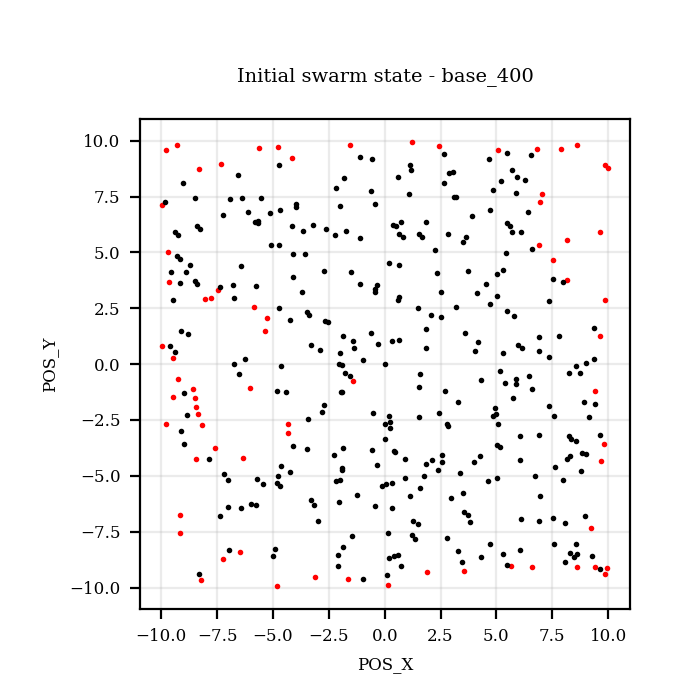

In [128]:
b, params = load_swarm('experiments/config/paper/base_400.json')
show_swarm(b, params, 'experiments/config/paper/base_400.json', 'Initial swarm state', saved_figure='fig/base_400_init.pdf')

<IPython.core.display.Javascript object>


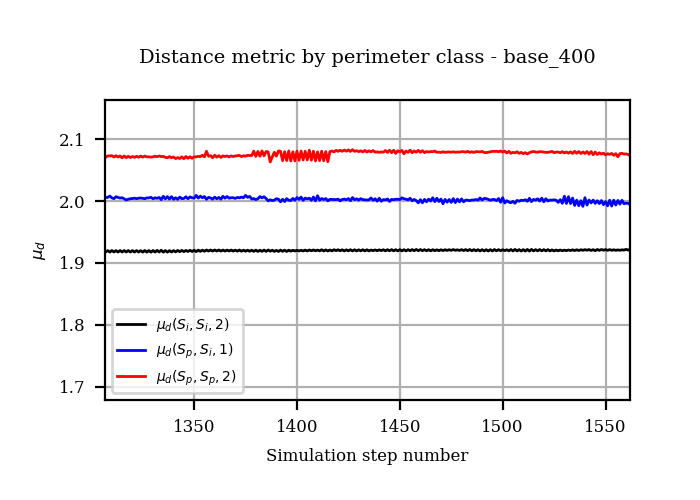

In [129]:
b, params = plot_k_mu_d_rel('experiments/config/paper/base_400.json', n_steps=2000, with_stdev=False, saved_figure='fig/base_400_d_2000.pdf')

In [20]:
# b, params = plot_mu_cr('experiments/config/dk_base_400.json', n_steps=2000, mu_sigma=mu_sigma_cr1, with_stdev=True)

In [21]:
# b, params = plot_mu_cr_rel('experiments/config/dk_base_400.json', n_steps=2000, mu_sigma=mu_sigma_cr1_rel, with_stdev=True)

<IPython.core.display.Javascript object>


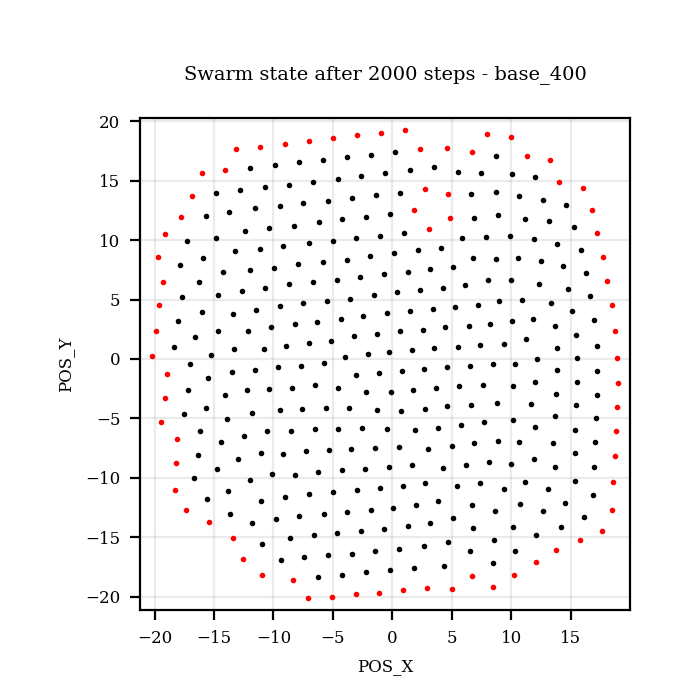

In [130]:
show_swarm(b, params, 'experiments/config/paper/base_400.json', 'Swarm state after 2000 steps', saved_figure='fig/base_400_step_2000.pdf')

<IPython.core.display.Javascript object>


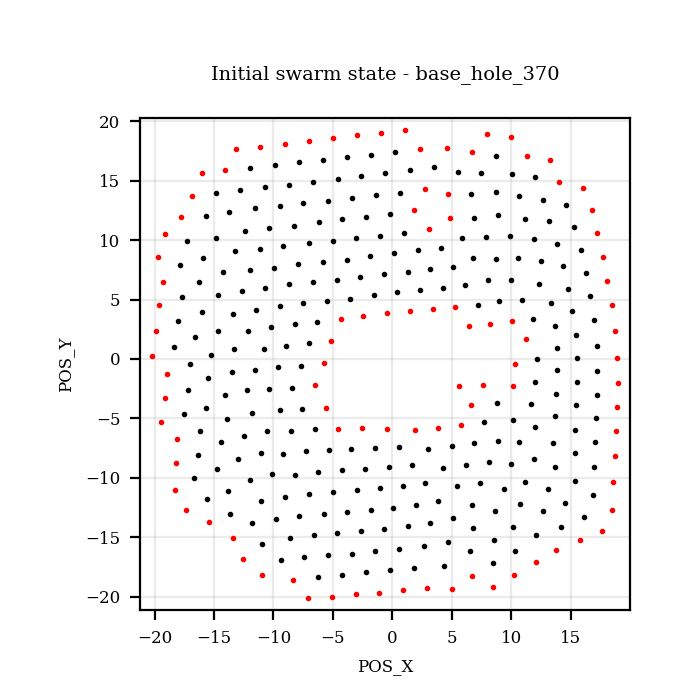

In [131]:
b, params = load_swarm('experiments/config/paper/base_hole_370.json')
show_swarm(b, params, 'experiments/config/paper/base_hole_370.json', 'Initial swarm state', saved_figure='fig/base_hole_370_init.pdf')

<IPython.core.display.Javascript object>


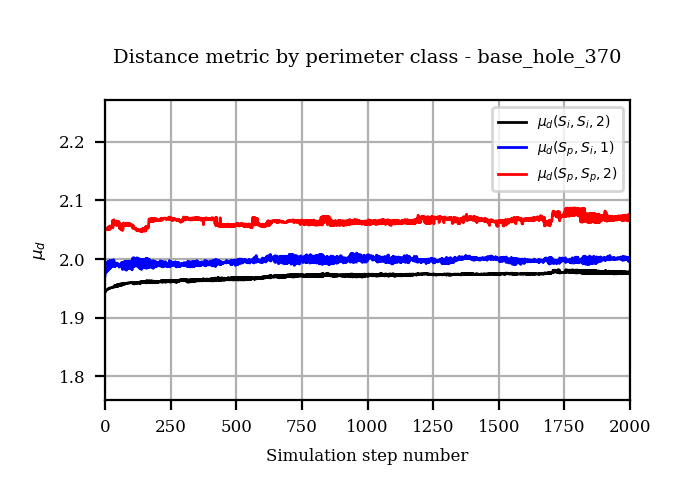

In [132]:
b, params = plot_k_mu_d_rel('experiments/config/paper/base_hole_370.json', n_steps=2000, with_stdev=False, saved_figure='fig/base_hole_370_d_2000.pdf')

In [25]:
# b, params = plot_mu_cr_rel('experiments/config/dk_kgonly_400.json', n_steps=2000, with_stdev=True)

<IPython.core.display.Javascript object>


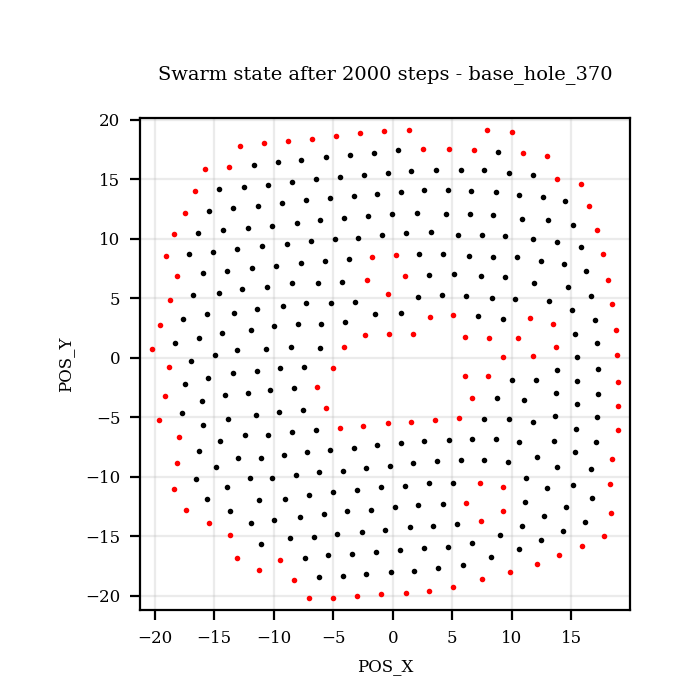

In [133]:
show_swarm(b, params, 'experiments/config/paper/base_hole_370.json', 'Swarm state after 2000 steps', saved_figure='fig/base_hole_370_step_2000.pdf')

In [27]:
xv, yv, mag = all_pairs_mag2(b)
d = np.amax(mag) 
a = np.pi * (d / 2) * (d / 2)
d, a

(45.51200814720882, 1626.828898110015)

<IPython.core.display.Javascript object>


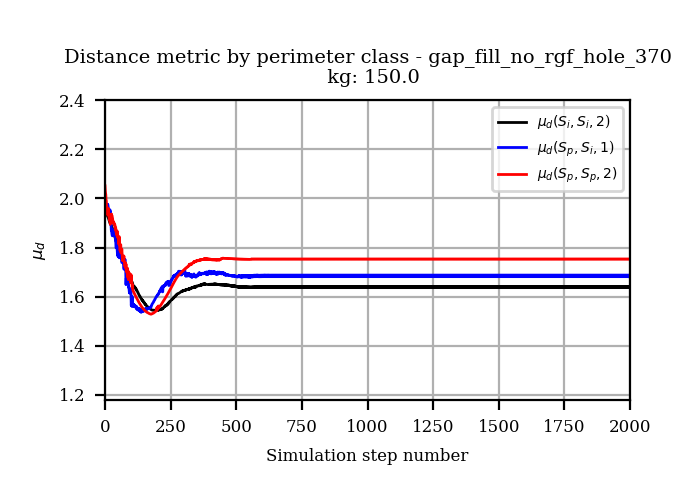

In [266]:
b, params, means, stdevs = plot_k_mu_d_rel('experiments/config/paper/gap_fill_no_rgf_hole_370.json', n_steps=2000, with_stdev=False, saved_figure='fig/gap_fill_no_rgf_hole_370_d_2000.pdf')

In [268]:
means[3][1990:]

array([1.75277356, 1.75322766, 1.75277356, 1.75322766, 1.75277356,
       1.75322766, 1.75277356, 1.75322766, 1.75277356, 1.75322766])

<IPython.core.display.Javascript object>


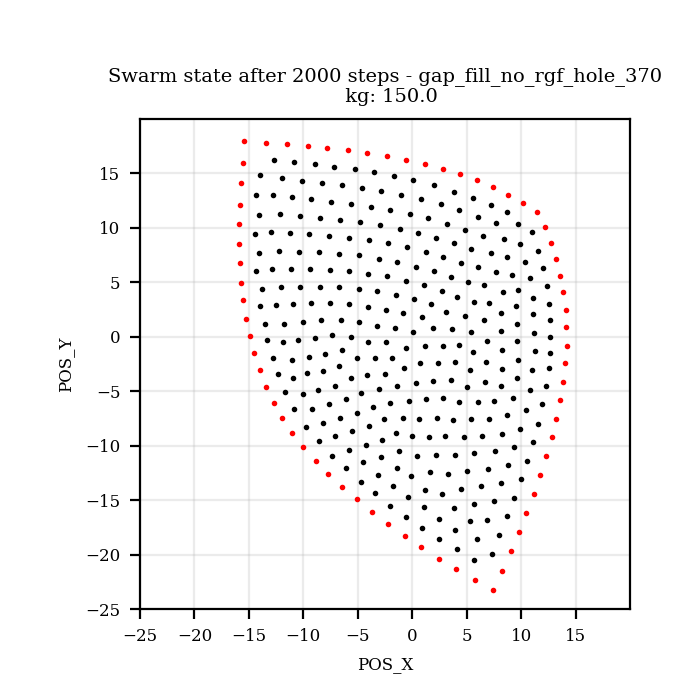

In [29]:
show_swarm(b, params, 'experiments/config/paper/gap_fill_no_rgf_hole_370.json', 'Swarm state after 2000 steps', ax_min_max=[-25, 20, -25, 20], step=5, saved_figure='fig/gap_fill_no_rgf_hole_370_step_2000.pdf')

In [30]:
# x_limits = (np.amin(b[POS_X]) - 5, np.amax(b[POS_X]) + 5)
# y_limits = (np.amin(b[POS_Y]) - 5, np.amax(b[POS_Y]) + 5)
# sim = run_simulation(b, with_perimeter=True, step=d_step, x_limits=x_limits, y_limits=y_limits, **params)

<IPython.core.display.Javascript object>


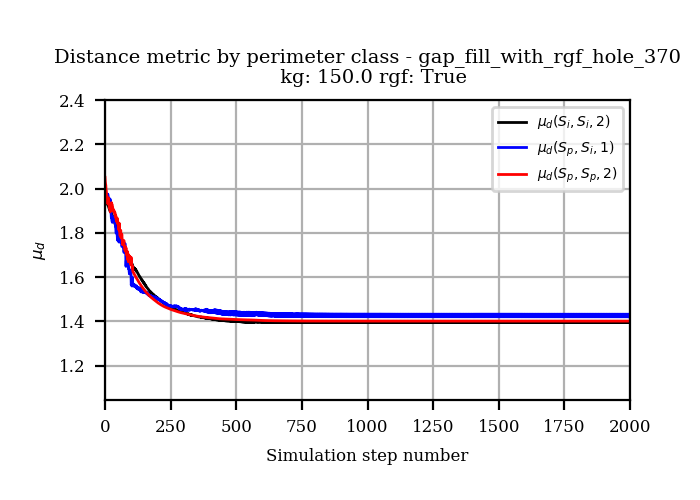

In [806]:
b, params, means, stdevs = plot_k_mu_d_rel('experiments/config/paper/gap_fill_with_rgf_hole_370.json', n_steps=2000, with_stdev=False, saved_figure='fig/gap_fill_with_rgf_hole_370_d_2000.pdf')

<IPython.core.display.Javascript object>


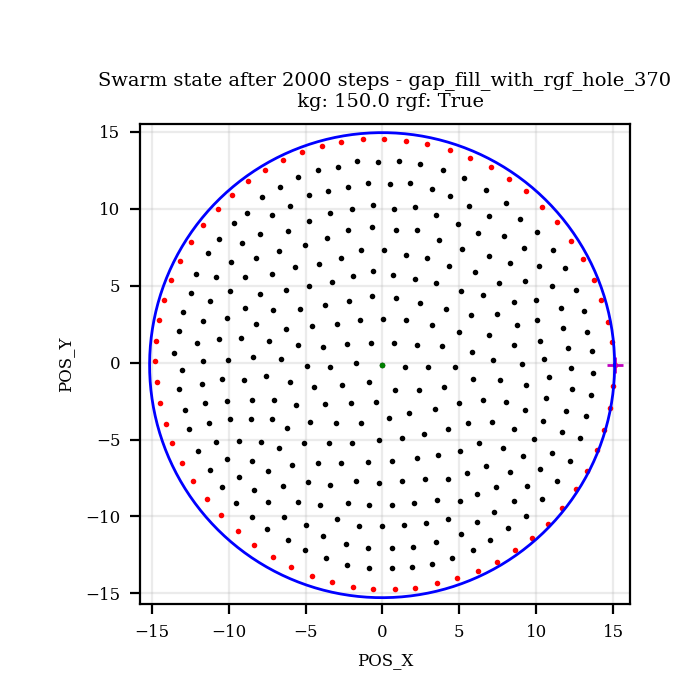

In [807]:
ax = show_swarm(b, params, 'experiments/config/paper/gap_fill_with_rgf_hole_370.json', 'Swarm state after 2000 steps', with_circle=True, saved_figure='fig/gap_fill_with_rgf_hole_370_step_2000.pdf')

In [804]:
plot_swarm_circle(b, ax)

In [803]:
mse_circle(b)

0.05604569817080931

<IPython.core.display.Javascript object>


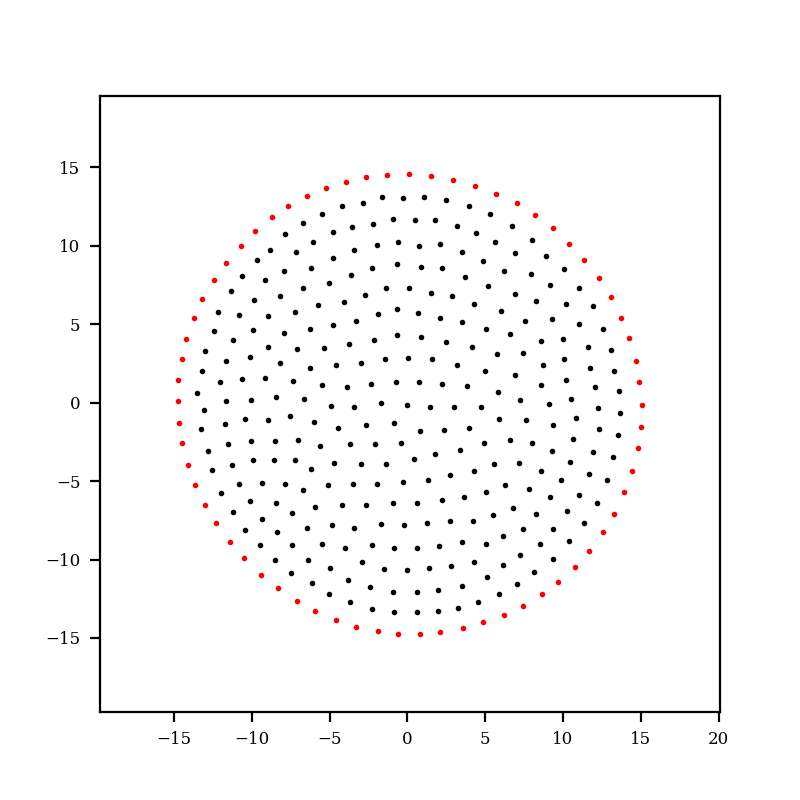

In [77]:
x_limits = (np.amin(b[POS_X]) - 5, np.amax(b[POS_X]) + 5)
y_limits = (np.amin(b[POS_Y]) - 5, np.amax(b[POS_Y]) + 5)
sim = run_simulation(b, with_perimeter=True, step=d_step, x_limits=x_limits, y_limits=y_limits, **params)

<IPython.core.display.Javascript object>


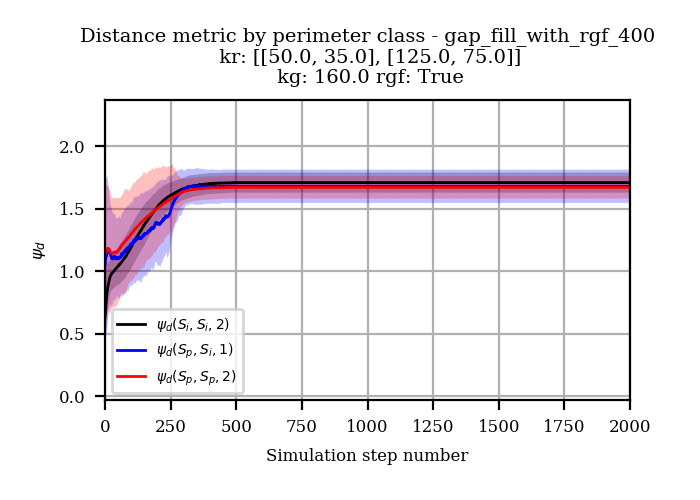

In [835]:
a, p = agent_perimeter_status(n_steps=2000, config_file='experiments/config/paper/gap_fill_with_rgf_400.json')
b, params, means, stdevs = plot_k_mu_d_rel('experiments/config/paper/gap_fill_with_rgf_400.json', n_steps=2000, pre_p=p, with_stdev=True, saved_figure='fig/gap_fill_with_rgf_400_ds_pre_p_2000.pdf')

<IPython.core.display.Javascript object>


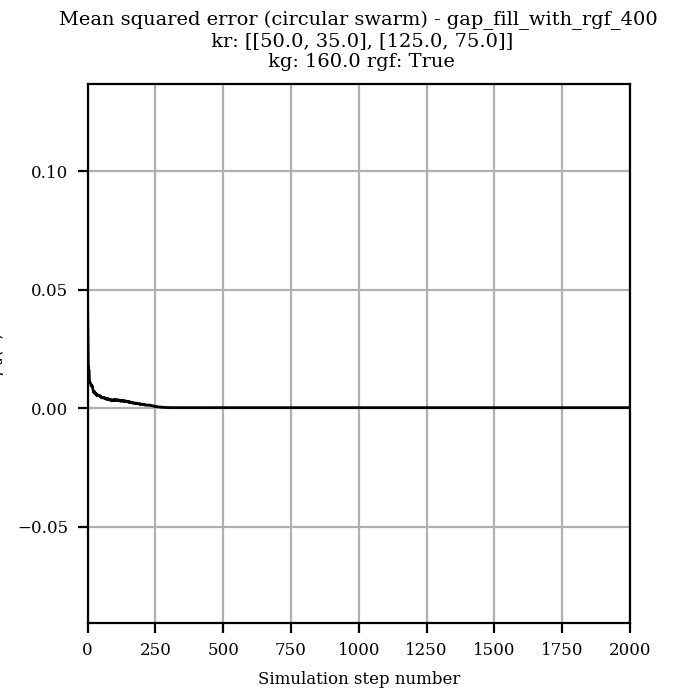

(array([[ 2.11792221e+00,  3.40260457e+00,  1.22582235e+01, ...,
          8.65847779e-01,  1.60828948e+01,  1.70350380e+01],
        [-1.49675672e-01,  4.77905837e+00, -4.25255214e+00, ...,
         -1.62810460e+01,  1.61893587e+00, -6.10414191e+00],
        [ 3.10773458e-02,  1.90385456e-02, -2.70413059e-02, ...,
          1.17894415e-02,  9.95298945e-03, -1.37134265e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  1.37570318e+01],
        [ 7.00000000e+00,  7.00000000e+00,  7.00000000e+00, ...,
          8.00000000e+00,  7.00000000e+00,  5.00000000e+00],
        [ 6.00000000e+00,  6.00000000e+00,  5.00000000e+00, ...,
          4.00000000e+00,  6.00000000e+00,  3.00000000e+00]]),
 {'cb': 3.0,
  'rb': array([[2., 2.],
         [2., 2.]]),
  'kc': array([[0.15, 0.15],
         [0.15, 0.15]]),
  'kr': array([[ 50.,  35.],
         [125.,  75.]]),
  'kd': 0.0,
  'kg': 160.0,
  'scaling': 'linear',
  'exp_rate

In [850]:
plot_mse_circle('experiments/config/paper/gap_fill_with_rgf_400.json', n_steps=2000)

<IPython.core.display.Javascript object>


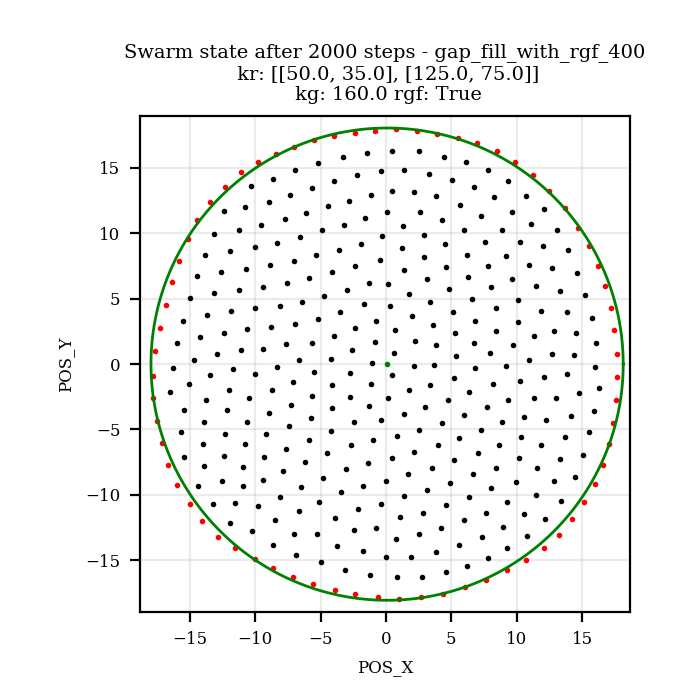

In [836]:
ax = show_swarm(b, params, 'experiments/config/paper/gap_fill_with_rgf_400.json', 'Swarm state after 2000 steps', with_circle=False, saved_figure='fig/gap_fill_with_rgf_400_step_2000.pdf')

In [837]:
plot_swarm_circle(b, ax, method='mean')

In [829]:
mse_circle(b)

0.0009529368915189755

In [830]:
mse_circle(b,method='mean')

0.00024801131782870944

<IPython.core.display.Javascript object>


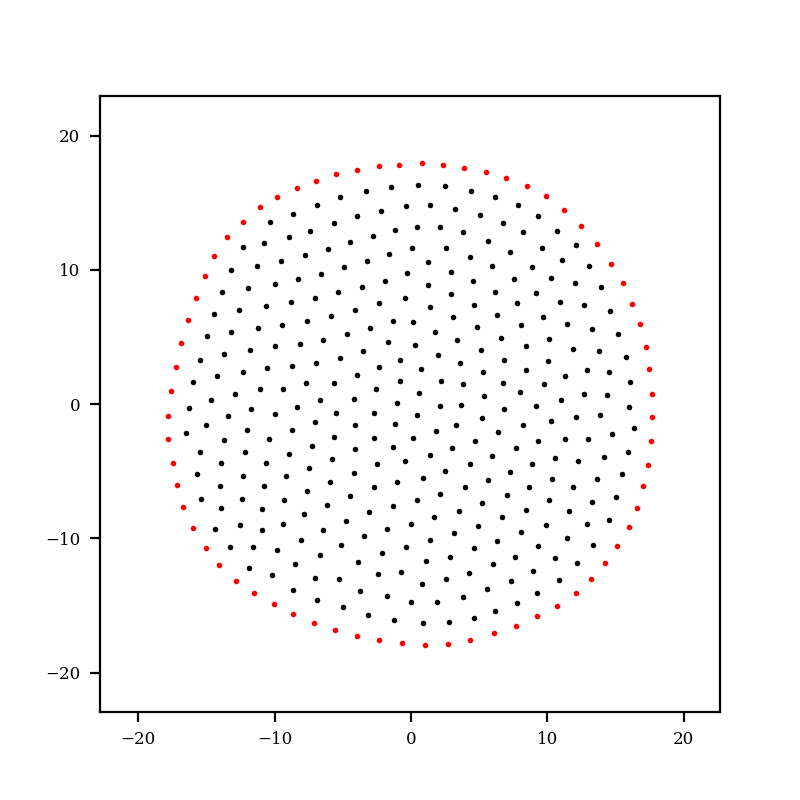

In [673]:
x_limits = (np.amin(b[POS_X]) - 5, np.amax(b[POS_X]) + 5)
y_limits = (np.amin(b[POS_Y]) - 5, np.amax(b[POS_Y]) + 5)
sim = run_simulation(b, with_perimeter=True, step=d_step, x_limits=x_limits, y_limits=y_limits, **params)

<IPython.core.display.Javascript object>


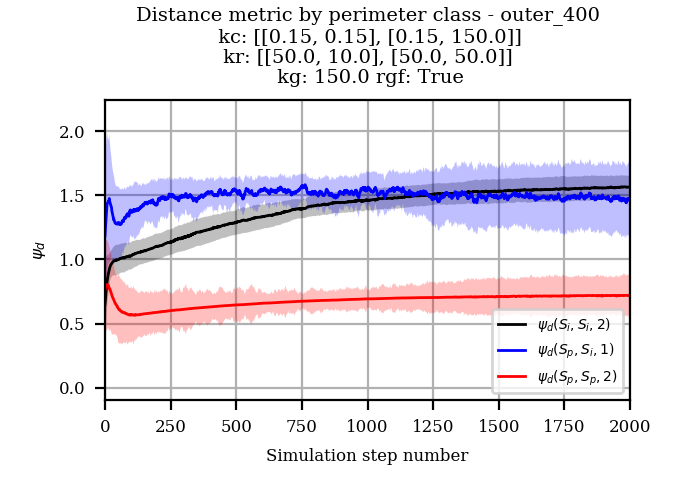

In [883]:
a, p = agent_perimeter_status(n_steps=2000, config_file='experiments/config/paper/outer_400.json')
b, params, means, stdevs = plot_k_mu_d_rel('experiments/config/paper/outer_400.json', n_steps=2000, with_stdev=True, pre_p=p, saved_figure='fig/outer_400_ds_pre_p_2000.pdf')

In [471]:
means[0][1990:]

array([1.56290785, 1.56313725, 1.56354985, 1.56294592, 1.56338014,
       1.56383108, 1.56383279, 1.56496122, 1.56405634, 1.56389921])

<IPython.core.display.Javascript object>


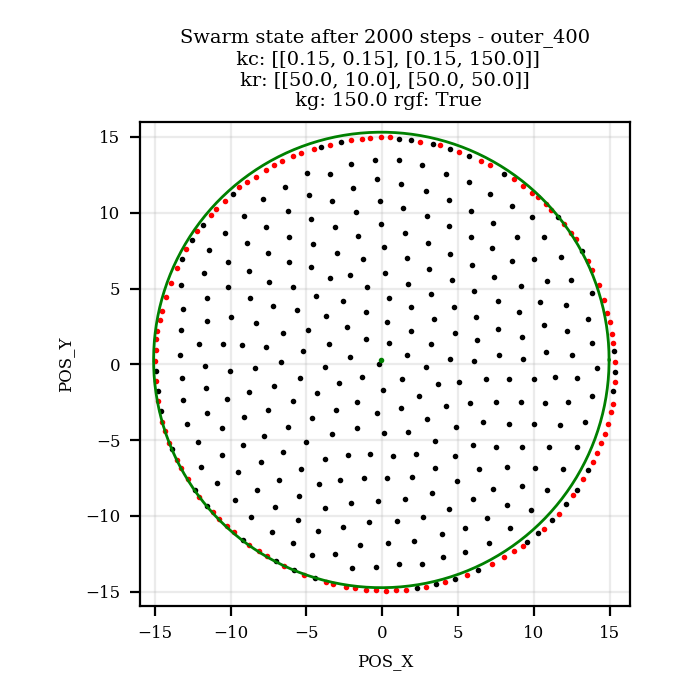

In [884]:
ax = show_swarm(b, params, 'experiments/config/paper/outer_400.json', 'Swarm state after 2000 steps', with_circle=True, saved_figure='fig/outer_400_step_2000.pdf')

In [885]:
mse_circle(b)

(0.07809582734877206, 0.07871917709315349)

In [796]:
plot_swarm_circle(b, ax)

In [337]:
37 / (98.0 + 37.0)

0.2740740740740741

In [36]:
# x_limits = (np.amin(b[POS_X]) - 5, np.amax(b[POS_X]) + 5)
# y_limits = (np.amin(b[POS_Y]) - 5, np.amax(b[POS_Y]) + 5)
# sim = run_simulation(b, with_perimeter=True, step=d_step, x_limits=x_limits, y_limits=y_limits, **params)

In [37]:
# b, params = plot_k_mu_d_rel('experiments/config/paper/outer2_400.json', n_steps=2000, with_stdev=True, saved_figure='fig/outer2_400_d_k12_2000.pdf')

In [38]:
# b, params = plot_mu_cr_rel('experiments/config/dk_outer_400.json', n_steps=2000, with_stdev=True)

In [39]:
# show_swarm(b, params, 'experiments/config/paper/outer2_400.json', 'Swarm state after 2000 steps', saved_figure='fig/outer2_400_step_2000.pdf')

In [40]:
# x_limits = (np.amin(b[POS_X]) - 5, np.amax(b[POS_X]) + 5)
# y_limits = (np.amin(b[POS_Y]) - 5, np.amax(b[POS_Y]) + 5)
# sim = run_simulation(b, with_perimeter=True, step=d_step, x_limits=x_limits, y_limits=y_limits, **params)

In [41]:
xv, yv, mag = all_pairs_mag2(b)
d = np.amax(mag) 
a = np.pi * (d / 2) * (d / 2)
d, a

(30.40139388853057, 725.9001294668627)

In [42]:
# x_limits = (np.amin(b[POS_X]) - 5, np.amax(b[POS_X]) + 5)
# y_limits = (np.amin(b[POS_Y]) - 5, np.amax(b[POS_Y]) + 5)
# sim = run_simulation(b, with_perimeter=True, step=d_step, x_limits=x_limits, y_limits=y_limits, **params)

<IPython.core.display.Javascript object>


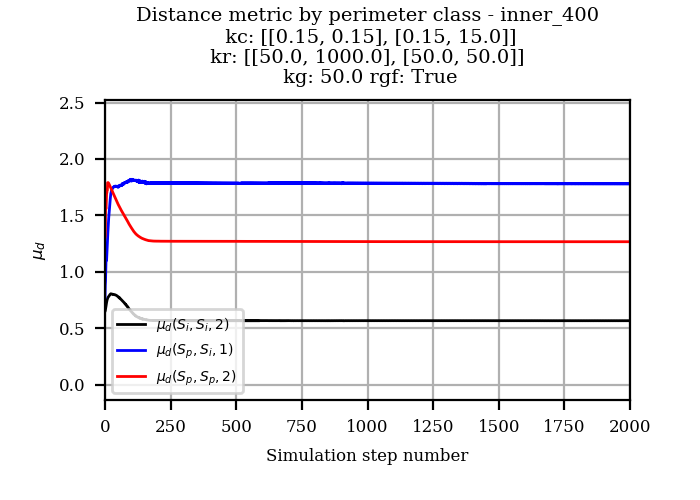

In [831]:
b, params, means, stdevs = plot_k_mu_d_rel('experiments/config/paper/inner_400.json', n_steps=2000, with_stdev=False, saved_figure='fig/inner_400_d_2000.pdf')

In [44]:
# b, params = plot_mu_cr_rel('experiments/config/paper/inner_400.json', n_steps=2000, with_stdev=True)

<IPython.core.display.Javascript object>


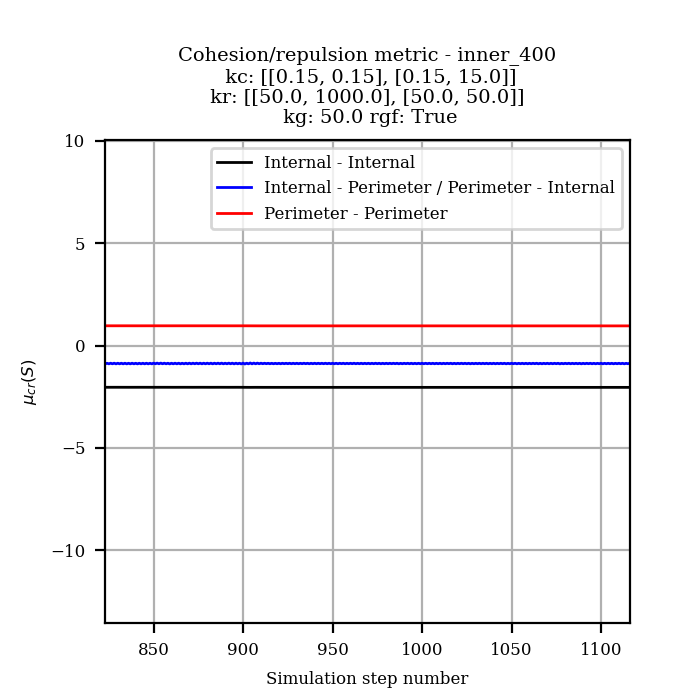

In [891]:
b, params = plot_mu_cr_rel('experiments/config/paper/inner_400.json', n_steps=2000, with_stdev=False, saved_figure='fig/inner_400_cr_2000.pdf')

In [265]:
means[3][1990:]

array([1.26645236, 1.26639028, 1.26643481, 1.26641507, 1.26645105,
       1.26642633, 1.26645893, 1.26638765, 1.26642899, 1.26641469])

<IPython.core.display.Javascript object>


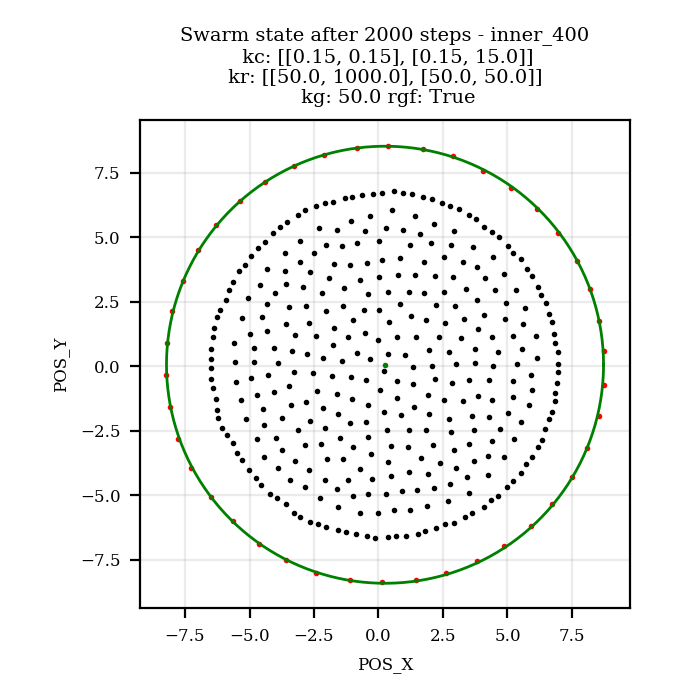

In [832]:
ax = show_swarm(b, params, 'experiments/config/paper/inner_400.json', 'Swarm state after 2000 steps', with_circle=False, saved_figure='fig/inner_400_step_2000.pdf')

In [818]:
mse_circle(b)

7.52849430453241e-05

In [833]:
plot_swarm_circle(b,ax,method='mean')

In [834]:
mse_circle(b,method='mean')

1.6661572226539456e-05

In [779]:
r, mag = radius(b, c)

In [787]:
np.sum((1. - (mag[b[PRM].astype(np.bool)] / r)) ** 2)

0.0031619676079036123

In [46]:
# b = mk_rand_swarm(400)
# step_args = default_swarm_params.copy()
# step_args['rb'] = np.array(step_args['rb'])
# step_args['kc'] = np.array(step_args['kc'])
# step_args['kr'] = np.array(step_args['kr'])
# dump_swarm(b, step_args, 'experiments/config/dk_base_400.json')

In [47]:
def mu_nc(b):
    xv, yv, mag = all_pairs_mag2(b)
    # compute the cohesion neighbours
    coh_n = mag <= 3
    np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
    b[COH_N] = np.sum(coh_n, axis = 0) # number of cohesion neighbours
    return np.average(b[COH_N])

In [48]:
# b, params = plot_mu_cr_rel('experiments/config/paper/outer_with_void_400.json', n_steps=2000, with_stdev=True)

In [49]:
# b, params = load_swarm('experiments/config/paper/outer_with_hole_370.json')
# show_swarm(b, params, 'experiments/config/paper/outer_with_hole_370.json', 'Initial state')

In [50]:
# b, params = plot_mu_d_rel('experiments/config/paper/outer_with_hole_370.json', n_steps=2000, with_stdev=False)

In [51]:
# b, params = plot_mu_cr('experiments/config/dk_outer_400_hole.json', n_steps=2000, with_stdev=True)

In [52]:
# b, params = plot_mu_cr_rel('experiments/config/dk_outer_400_hole.json', n_steps=2000, with_stdev=True)

In [53]:
# show_swarm(b, params, 'experiments/config/paper/outer_with_hole_370.json', 'Swarm state after 2000 steps')

In [54]:
# x_limits = (np.amin(b[POS_X]) - 5, np.amax(b[POS_X]) + 5)
# y_limits = (np.amin(b[POS_Y]) - 5, np.amax(b[POS_Y]) + 5)
# sim = run_simulation(b, with_perimeter=True, step=d_step, x_limits=x_limits, y_limits=y_limits, **params)

<IPython.core.display.Javascript object>


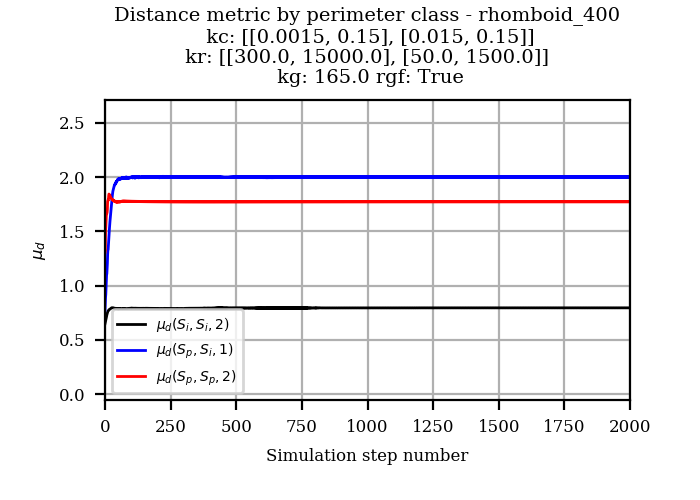

In [142]:
b, params = plot_k_mu_d_rel('experiments/config/paper/rhomboid_400.json', n_steps=2000, with_stdev=False, saved_figure='fig/rhomboid_400_d_2000.pdf')

<IPython.core.display.Javascript object>


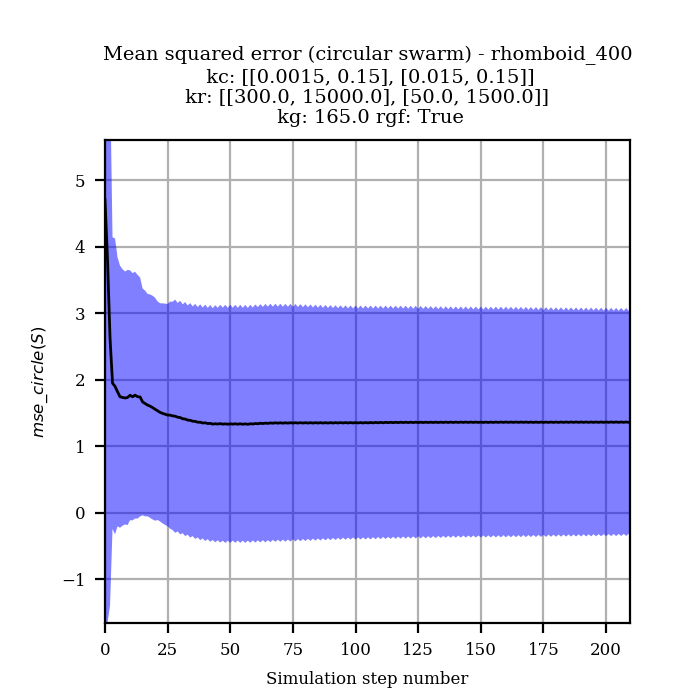

In [864]:
b, params, means, stdevs = plot_mse_circle('experiments/config/paper/rhomboid_400.json', n_steps=2000, with_stdev=True)

<IPython.core.display.Javascript object>


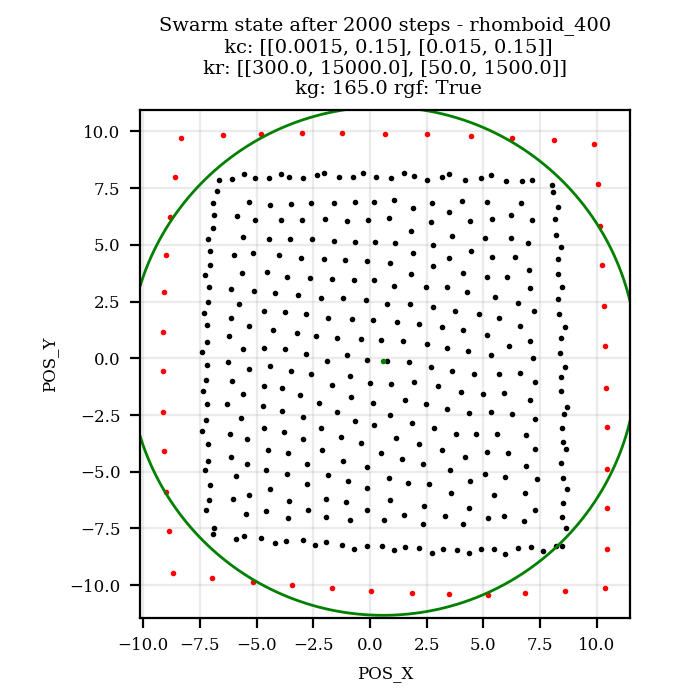

In [862]:
ax = show_swarm(b, params, 'experiments/config/paper/rhomboid_400.json', 'Swarm state after 2000 steps', with_circle=True, saved_figure='fig/rhomboid_400_step_2000.pdf')

In [ ]:
plot_swarm_circle

In [886]:
def centroid(b, perim_only=False):
    n_agents = b.shape[1]
    if perim_only:
        p = b[PRM].astype(bool)
        result = np.array([np.mean(b[POS_X,p]), np.mean(b[POS_Y,p])])
    else:
        result = np.array([np.sum(b[POS_X]), np.sum(b[POS_Y])]) / n_agents
    return result

def radius(b, centre, method='mean'):
    mag = np.hypot(b[POS_X] - centre[0], b[POS_Y] - centre[1])
    if method == 'max':
        r = np.amax(mag)
    else:
        r = np.mean(mag[b[PRM].astype(bool)])
    return r, mag

def plot_swarm_circle(b, ax, method='mean'):
    c = centroid(b)
    ax.plot([c[0]], [c[1]], 'go', markersize=1)
    r, mag = radius(b, c, method)
    theta = np.linspace(0, 2*np.pi, 500)
    x = r * np.cos(theta) + c[0]
    y = r * np.sin(theta) + c[1]
    if method == 'max':
        a = np.nonzero(mag == r)
        ax.plot([b[POS_X, a[0][0]]], [b[POS_Y, a[0][0]]], 'm+')
        ax.plot(x, y, 'b-')
    else:
        ax.plot(x, y, 'g-')
    
def agent_perimeter_status(n_steps=2000, start=0, boundary=50, config_file='experiments/config/paper/base_400.json'):
    b, params = load_swarm(config_file)
    n_agents = b.shape[1]
    accum = np.zeros((n_agents,))
    for i in range(n_steps):
        compute_step(b, **params)
        if i >= start:
            accum += b[PRM]
        apply_step(b)
    accum = (accum / (n_steps - start)) * 100.0
    p = np.where(accum > boundary, 1, 0)
    return accum, p

def plot_agent_data(data):
    fig, ax = plt.subplots()
    x = list(range(len(data)))
    ax.plot(x, data)
    
def mse_circle(b, method='mean'):
    c = centroid(b)
    r, mag = radius(b, c, method)
    data = (r - (mag[b[PRM].astype(np.bool)])) ** 2
    return np.mean(data), np.std(data)

In [857]:
mse_circle(b)

(1.2824447535882566, 1.506257747286181)

In [890]:
p = b[PRM].astype(bool)
len(b[POS_X,p])

98

In [59]:
# b, params = load_swarm('experiments/config/paper/outer_with_hole_370.json')
# show_swarm(b, params, 'experiments/config/paper/outer_with_hole_370.json', 'Initial swarm state', saved_figure='fig/outer_with_hole_370_init.pdf')

In [60]:
# b, params = plot_k_mu_d_rel('experiments/config/paper/outer_with_hole_370.json', n_steps=2000, with_stdev=False, saved_figure='fig/outer_with_hole_370_ds_k612_2000.pdf')

In [61]:
# show_swarm(b, params, 'experiments/config/paper/outer_with_hole_370.json', 'Swarm state after 2000 steps', saved_figure='fig/outer_with_hole_370_step_2000.pdf')

In [62]:
def cross(s1, s2):
    n = len(s1)
    assert(n == len(s2))
    return {(p,q) for p in s1 for q in s2}

def id_rel(b):
    n_agents = b.shape[1]
    s = range(n_agents)
    return {(p,q) for (p,q) in cross(s,s) if p == q}

def i_agents(b):
    return {i for i in range(b.shape[1]) if not b[PRM, i]}

def p_agents(b):
    return {i for i in range(b.shape[1]) if b[PRM, i]}
 
def r_ii(b):
    ia = i_agents(b)
    return cross(ia, ia)

def r_ip(b):
    n_agents = b.shape[1]
    s = range(n_agents)
    return {(p,q) for (p,q) in cross(s, s) if not b[PRM, p] and b[PRM, q]}

def r_pi(b):
    n_agents = b.shape[1]
    s = range(n_agents)
    return {(p,q) for (p,q) in cross(s, s) if b[PRM, p] and not b[PRM, q]}

def r_pp(b):
    pa = p_agents(b)
    return cross(pa, pa)

def p_eq(b, p1, p2):
    return b[PRM, p1[0]] == b[PRM, p2[0]] and b[PRM, p1[1]] == b[PRM, p2[1]]

def eq_classes(b):
    n_agents = b.shape[1]
    s = range(n_agents)
    ss = cross(s,s)
    ia = list(i_agents(b)) 
    pa = list(p_agents(b))
    ii_rep = (ia[0], ia[1])
    ip_rep = (ia[0], pa[0])
    pi_rep = (pa[0], ia[0])
    pp_rep = (pa[0], pa[1])
    ii_class = {(p,q) for (p,q) in ss if p_eq(b, (p,q), ii_rep)}
    ip_class = {(p,q) for (p,q) in ss if p_eq(b, (p,q), ip_rep)}
    pi_class = {(p,q) for (p,q) in ss if p_eq(b, (p,q), pi_rep)}
    pp_class = {(p,q) for (p,q) in ss if p_eq(b, (p,q), pp_rep)}
    return [ii_class, ip_class, pi_class, pp_class], [ii_rep, ip_rep, pi_rep, pp_rep]


In [63]:
b = mk_rand_swarm(20, grid=1.0)
params = default_swarm_params.copy()
params['rb'] = np.array(params['rb'])
params['kc'] = np.array([[0.15,0.15],[0.15,150.0]])
params['kr'] = np.array([[50.0,10.0],[50.0,50.0]])
params['kg'] = 150.0
params['rgf'] = True

In [64]:
for i in range(10000):
    compute_step(b, **params)

<IPython.core.display.Javascript object>


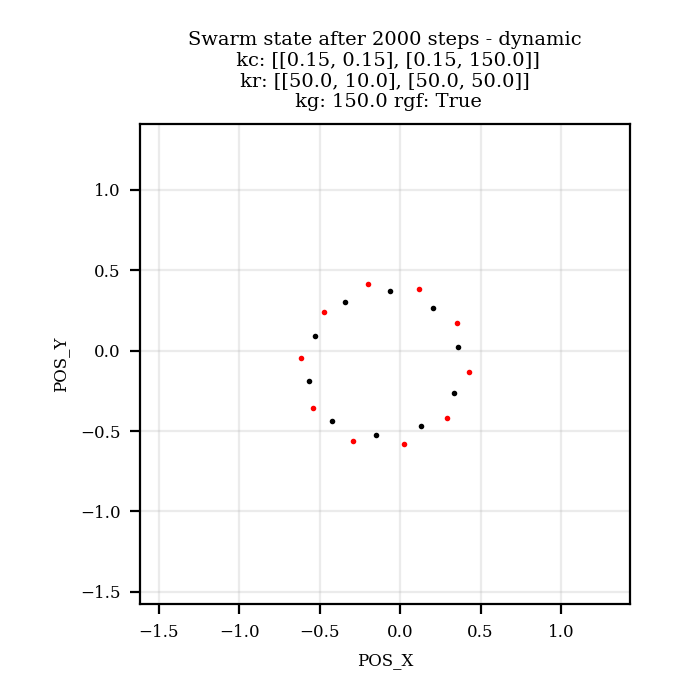

In [68]:
show_swarm(b, params, 'dynamic', 'Swarm state after 2000 steps')

<IPython.core.display.Javascript object>


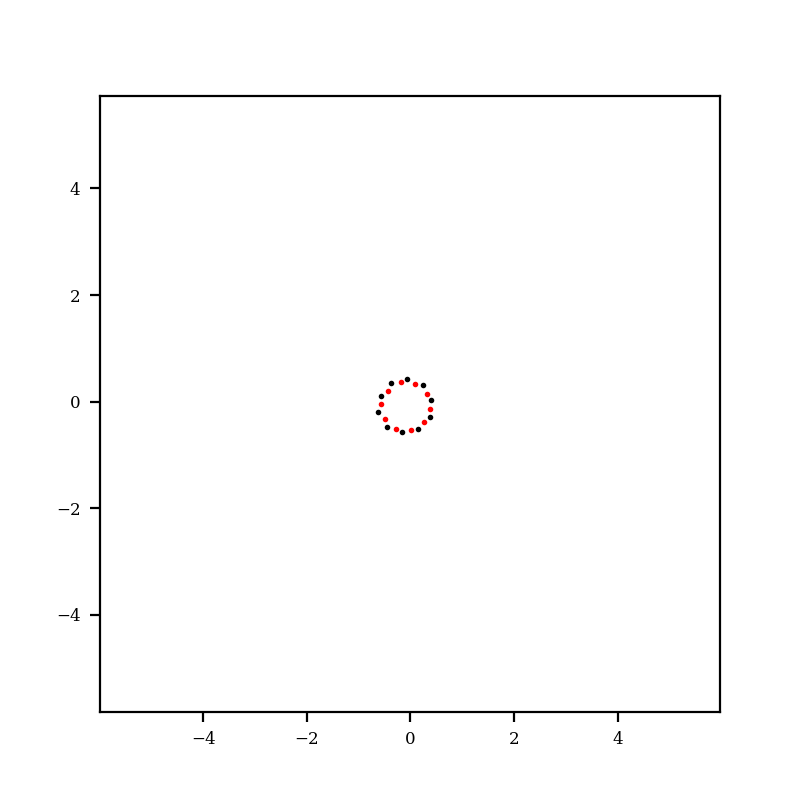

In [67]:
x_limits = (np.amin(b[POS_X]) - 5, np.amax(b[POS_X]) + 5)
y_limits = (np.amin(b[POS_Y]) - 5, np.amax(b[POS_Y]) + 5)
sim = run_simulation(b, with_perimeter=True, step=d_step, x_limits=x_limits, y_limits=y_limits, **params)

In [125]:
b, params = load_swarm('experiments/config/paper/inner_400.json')
run_distribution_experiments(n_exps=101, params=params, results_dir='experiments/data/inner_400/')

<IPython.core.display.Javascript object>


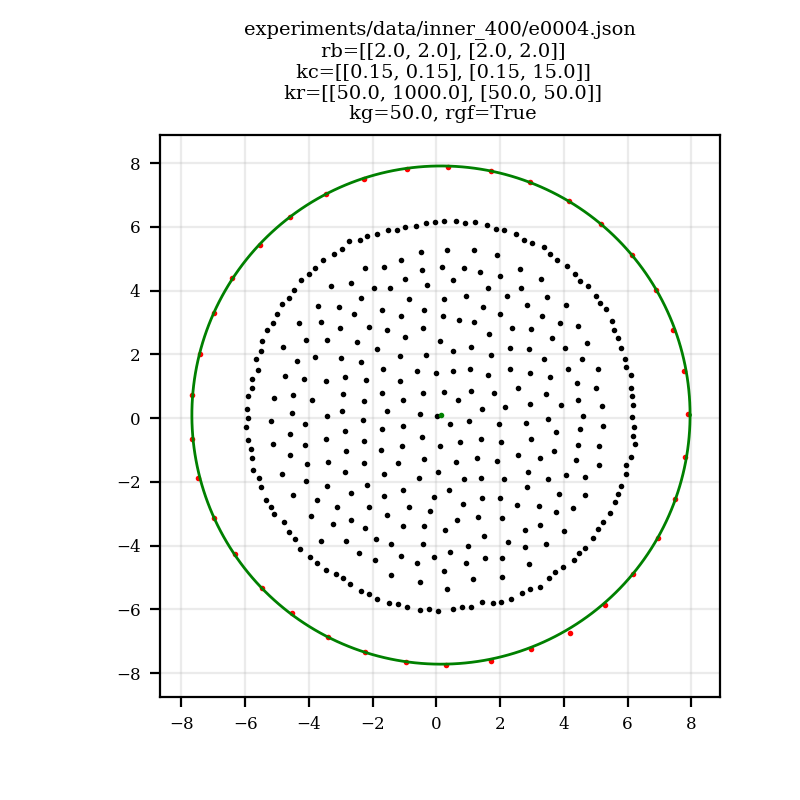

(<Figure size 800x800 with 1 Axes>, 9)

In [869]:
review_experiments(review_dir='experiments/data/inner_400/', start=0, with_circle=True)

In [738]:
a, p = agent_perimeter_status(n_steps=4000, start=0, config_file='experiments/config/paper/organic.json')

<IPython.core.display.Javascript object>


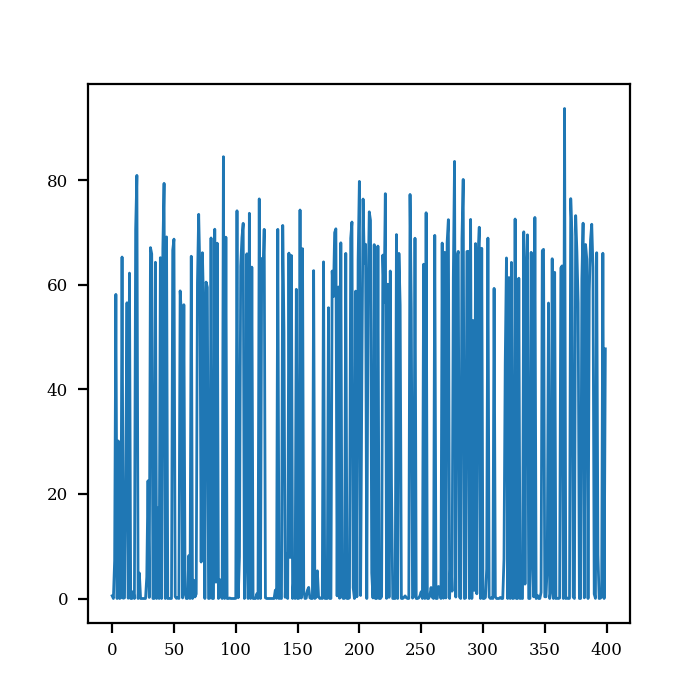

In [739]:
plot_agent_data(a)

In [740]:
np.count_nonzero(a > 50)

140

In [741]:
p

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,

In [708]:
p = np.zeros((n_agents,))

In [709]:
p = np.where(a > 50, 1, 0)

In [742]:
np.count_nonzero(p)

140

In [464]:
(5.0 / (400 - 131)) * 100

1.858736059479554

In [223]:
p.shape

(400,)

In [224]:
np.count_nonzero(p)

122

In [225]:
np.count_nonzero(b[PRM])

94

In [229]:
p

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,

<IPython.core.display.Javascript object>


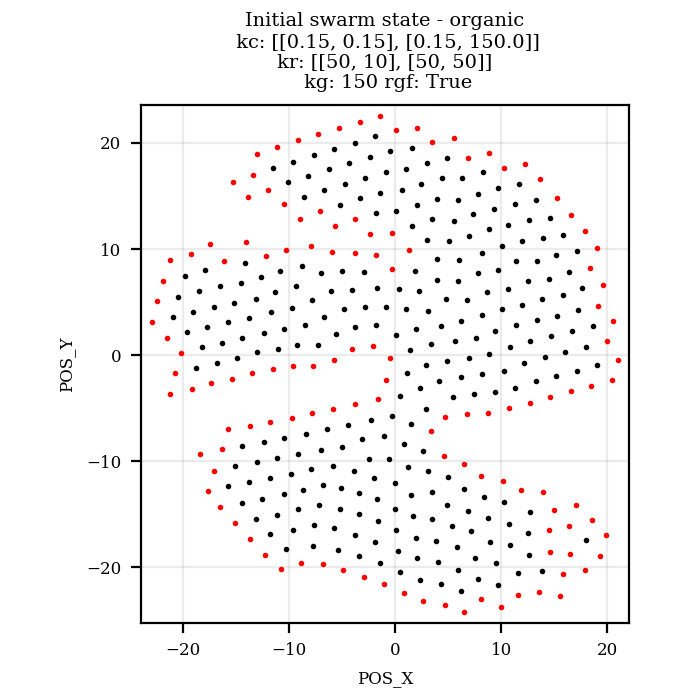

In [479]:
b, params = load_swarm('experiments/config/paper/organic.json')
show_swarm(b, params, 'experiments/config/paper/organic.json', 'Initial swarm state', saved_figure='fig/organic_init.pdf')

<IPython.core.display.Javascript object>


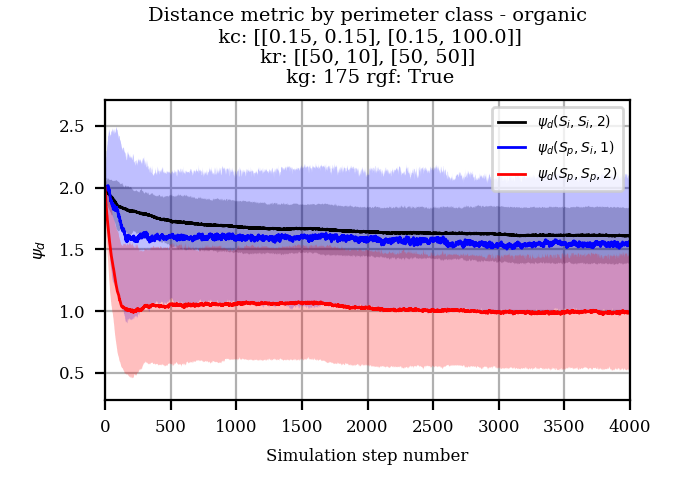

In [876]:
b, params, means, stdevs = plot_k_mu_d_rel('experiments/config/paper/organic.json', n_steps=4000, with_stdev=True, pre_p=p, saved_figure='fig/organic_ds_pre_p_2000.pdf')

<IPython.core.display.Javascript object>


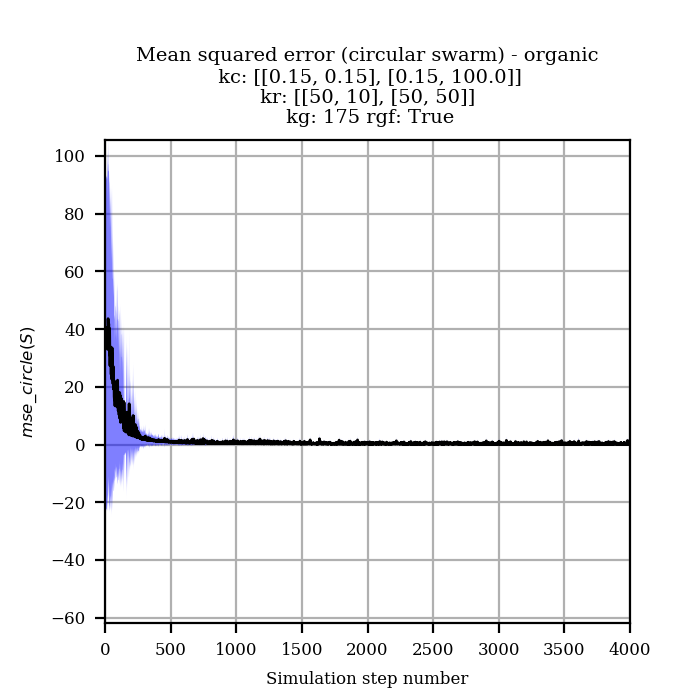

In [880]:
b, params, means, stdevs = plot_mse_circle('experiments/config/paper/organic.json', n_steps=4000, with_stdev=True)

<IPython.core.display.Javascript object>


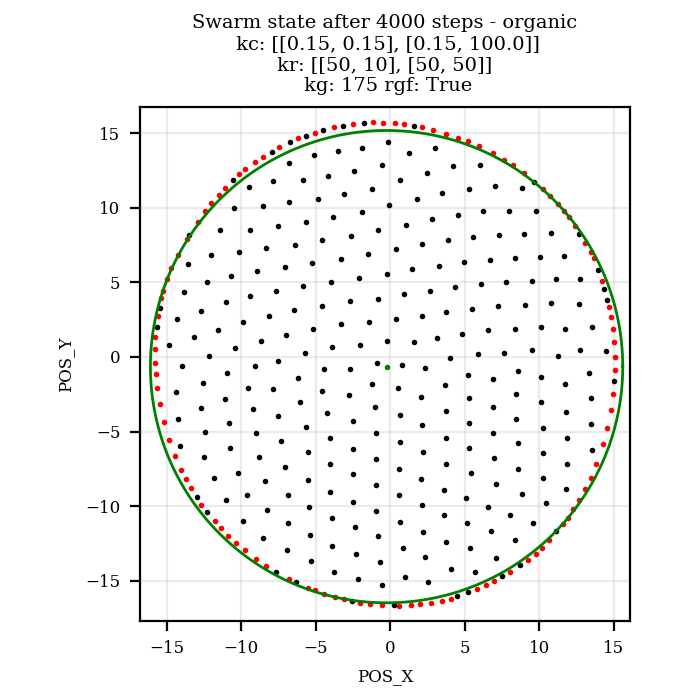

In [881]:
ax = show_swarm(b, params, 'experiments/config/paper/organic.json', 'Swarm state after 4000 steps', with_circle=True, saved_figure='fig/organic_step_4000.pdf')

In [882]:
mse_circle(b)

(0.10092505010551726, 0.10210685550096502)

In [730]:
c = centroid(b)
ax.plot([c[0]], [c[1]], 'go', markersize=1)
r, mag = radius(b, c)
a = np.nonzero(mag == r)
a[0][0]
# ax.plot([b[POS_X, a], b[POS_Y, a]], 'm+')
# theta = np.linspace(0, 2*np.pi, 500)
# x = r * np.cos(theta)
# y = r * np.sin(theta)
# ax.plot(x, y, 'b-')

220

In [735]:
plot_swarm_circle(b, ax)

<IPython.core.display.Javascript object>


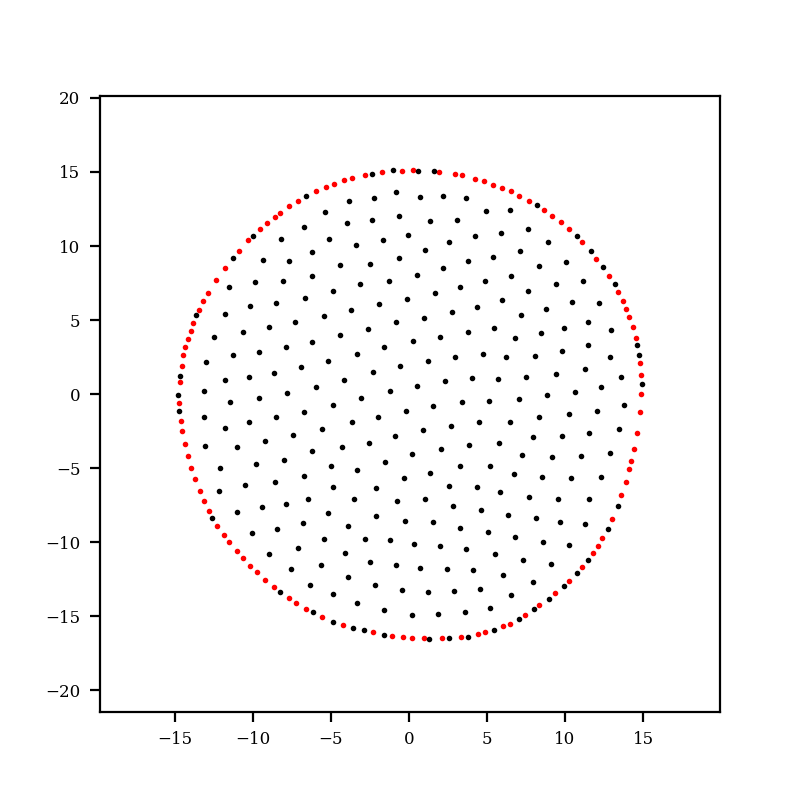

In [499]:
x_limits = (np.amin(b[POS_X]) - 5, np.amax(b[POS_X]) + 5)
y_limits = (np.amin(b[POS_Y]) - 5, np.amax(b[POS_Y]) + 5)
sim = run_simulation(b, with_perimeter=True, step=d_step, x_limits=x_limits, y_limits=y_limits, **params)

<IPython.core.display.Javascript object>


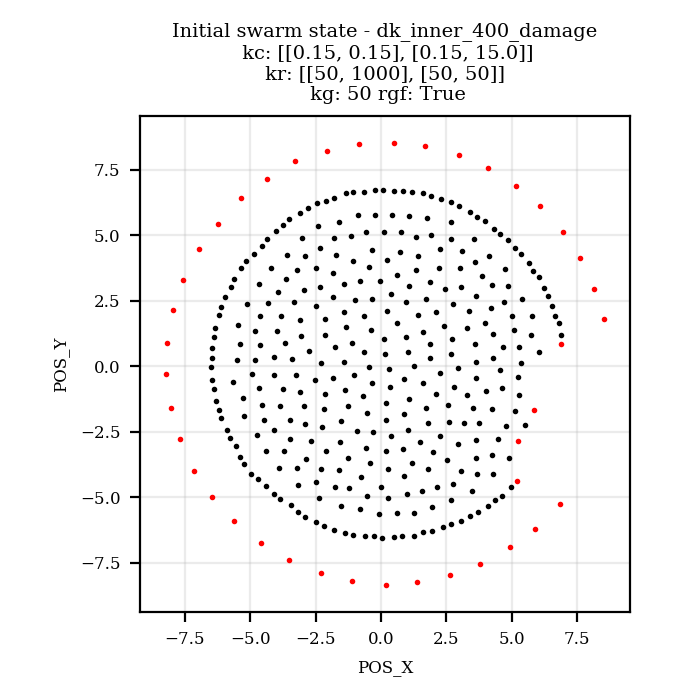

In [518]:
b, params = load_swarm('experiments/config/dk_inner_400_damage.json')
show_swarm(b, params, 'experiments/config/dk_inner_400_damage.json', 'Initial swarm state', saved_figure='fig/dk_inner_400_damage_init.pdf')

x_limits = (np.amin(b[POS_X]) - 5, np.amax(b[POS_X]) + 5)
y_limits = (np.amin(b[POS_Y]) - 5, np.amax(b[POS_Y]) + 5)
sim = run_simulation(b, with_perimeter=True, step=d_step, x_limits=x_limits, y_limits=y_limits, **params)

In [520]:
2 * np.pi

6.283185307179586

In [521]:
np.pi / 2

1.5707963267948966

In [522]:
3 * np.pi / 2

4.71238898038469

In [524]:
(1.5 - 4.5) + (2 * np.pi)

3.2831853071795862

In [526]:
((2 * np.pi) - 4.5) + 1.5

3.2831853071795862

Why do we need $\delta + 2\pi$ when $\delta$ is negative? Consider Fig. 2(b) where $b_i = b_3 = b'$ and $b_{(i+1) \% 4} = b_0 = b''$. Assume $\alpha(b, b'') = 1.5$ radians and $\alpha(b, b') = 4.5$ radians. So $\delta = \alpha(b, b'') - \alpha(b, b') = -3.0$ radians. The absolute value of $-3.0$ is $3.0$ which is less than $\pi$, so this would not count as a reflex angle, when clearly it should. $(2\pi - 4.5) + 1.5 = (1.5 - 4.5) + 2\pi = \delta + 2\pi = 3.283$, which is greater than $\pi$ and so is correctly identified as a reflex angle.

In [528]:
(1.5 - 4.5) + 2 * np.pi

3.2831853071795862